In [1]:
# Cell 1: Section 1 - Initialization: Imports
#
# Import all required libraries for the project.
#

# --- Core Libraries ---
import os
import sys
import logging
import time

# --- Data Handling ---
import pandas as pd
import numpy as np

import findspark
findspark.init()
# --- PySpark Core ---
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, avg, stddev, min, max, sum, lit, broadcast
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.window import Window

# --- PySpark ML (Preprocessing) ---
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

# --- PySpark ML (Models) ---
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
# from pyspark.ml.clustering import IsolationForest # Note: Requires Spark 3.0+ 
from sklearn.ensemble import IsolationForest
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Evaluation (Local) ---
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

print("="*80)
print("Cell 1: All libraries imported successfully.")
print(f"PySpark Version: {pyspark.__version__}")
print("="*80)

Cell 1: All libraries imported successfully.
PySpark Version: 2.4.8


In [2]:
# Cell 2: Section 1 - Logging and Path Configuration
#
# Configure logging, define all project paths, and create output directories.
#

# --- 1. Configure Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
log = logging.getLogger("FraudDetectionLogger")
log.info("Logging initialized.")

# --- 2. Define Project Paths ---
try:
    # Get the user's home directory 
    HOME_DIR = '/home/smitvd22' 
    
    # Base project directory
    PROJECT_DIR = os.path.join(HOME_DIR, 'SparkProject')
    
    # --- Local Paths (for initial ingest) ---
    LOCAL_DATASET_PATH = os.path.join(PROJECT_DIR, 'dataset', 'PS_20174392719_1491204439457_log.csv')
    
    # --- HDFS Paths (for all processing) ---
    HDFS_BASE_PATH = f"/user/smitvd22/fraud_detection"
    HDFS_DATA_PATH = f"{HDFS_BASE_PATH}/data/transactions.parquet"
    
    # --- Hive Configuration ---
    HIVE_DB_NAME = "fraud_detection_db"
    HIVE_TABLE_NAME = "transactions"
    
    # --- Output & Model Paths ---
    OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')
    PLOT_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    METRICS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'metrics')
    MODEL_OUTPUT_DIR = os.path.join(PROJECT_DIR, 'models') # Save models to local FS
    
    log.info(f"Project Directory: {PROJECT_DIR}")
    log.info(f"Local Dataset: {LOCAL_DATASET_PATH}")
    log.info(f"HDFS Parquet Path: {HDFS_DATA_PATH}")

    # --- 3. Create Local Output Directories ---
    os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)
    os.makedirs(METRICS_OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
    
    log.info(f"Created output plot directory: {PLOT_OUTPUT_DIR}")

    # --- 4. Visualization Settings ---
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300
    log.info("Seaborn and Matplotlib configured.")

except Exception as e:
    log.error(f"Error setting up paths: {e}")

print("="*80)
print("Cell 2: Logging and paths configured.")
print("="*80)

2025-11-08 18:24:40 - FraudDetectionLogger - INFO - Logging initialized.
2025-11-08 18:24:40 - FraudDetectionLogger - INFO - Project Directory: /home/smitvd22/SparkProject
2025-11-08 18:24:40 - FraudDetectionLogger - INFO - Local Dataset: /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-08 18:24:40 - FraudDetectionLogger - INFO - HDFS Parquet Path: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-08 18:24:41 - FraudDetectionLogger - INFO - Created output plot directory: /home/smitvd22/SparkProject/output/plots
2025-11-08 18:24:41 - FraudDetectionLogger - INFO - Seaborn and Matplotlib configured.


Cell 2: Logging and paths configured.


In [3]:
# Cell 3: Section 1 - Initialize SparkSession
#
# Start the SparkSession with Hive support and configurations 
# for processing a multi-GB dataset.
#

try:
    log.info("Building SparkSession...")
    
    spark = (
        SparkSession.builder
        .appName("PySpark_Fraud_Detection_Project")
        .enableHiveSupport()  # Enable integration with Hive Metastore
        
        # --- Configuration for ~6.3M records ---
        # Allocate 8GB to the driver (Jupyter)
        .config("spark.driver.memory", "8g")
        # Allocate 8GB to each executor
        .config("spark.executor.memory", "8g")
        # Increase shuffle partitions for better parallelism
        .config("spark.sql.shuffle.partitions", "200")
        # Use a more efficient serializer
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        # Increase the max result size for the driver (e.g., for .collect())
        .config("spark.driver.maxResultSize", "2g")
        
        .getOrCreate()
    )
    
    sc = spark.sparkContext
    
    log.info("SparkSession created successfully.")
    log.info(f"Spark UI available at: {sc.uiWebUrl}")

    # --- Create Hive Database ---
    spark.sql(f"CREATE DATABASE IF NOT EXISTS {HIVE_DB_NAME}")
    spark.sql(f"USE {HIVE_DB_NAME}")
    log.info(f"Hive database '{HIVE_DB_NAME}' created and in use.")

except Exception as e:
    log.error(f"Error initializing SparkSession: {e}")
    # Stop the notebook if Spark can't start
    raise e

print("="*80)
print("Cell 3: SparkSession initialized with Hive support.")
print("="*80)

2025-11-08 18:24:41 - FraudDetectionLogger - INFO - Building SparkSession...
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/smitvd22/hadoop-2.6.5/share/hadoop/common/lib/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
25/11/08 18:24:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2025-11-08 18:24:47 - FraudDetectionLogger - INFO - SparkSession created successfully.
2025-11-08 18:24:47 - FraudDetectionLogger - INFO - Spark UI available at: http:/

Cell 3: SparkSession initialized with Hive support.


In [4]:
# Cell 4: Section 2 - Data Ingest (Local CSV -> HDFS Parquet)
#
# Phase 1: Load the large local CSV, define the schema,
# and write it to HDFS in the optimized Parquet format.
#

try:
    log.info(f"Starting Phase 1: Ingesting local CSV from {LOCAL_DATASET_PATH}")
    
    # Define the schema to avoid slow 'inferSchema' on 6M rows
    schema = StructType([
        StructField("step", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("amount", DoubleType(), True),
        StructField("nameOrig", StringType(), True),
        StructField("oldbalanceOrg", DoubleType(), True),
        StructField("newbalanceOrig", DoubleType(), True),
        StructField("nameDest", StringType(), True),
        StructField("oldbalanceDest", DoubleType(), True),
        StructField("newbalanceDest", DoubleType(), True),
        StructField("isFraud", IntegerType(), True),
        StructField("isFlaggedFraud", IntegerType(), True)
    ])

    # Read from LOCAL filesystem (note the 'file://' prefix)
    df_raw = spark.read.csv(
        f"file://{LOCAL_DATASET_PATH}",
        header=True,
        schema=schema
    )
    
    log.info("Local CSV read successfully. Writing to HDFS Parquet...")

    # Write to HDFS in Parquet format. This is much faster for analysis.
    # 'overwrite' mode allows us to re-run this notebook
    df_raw.write.mode("overwrite").parquet(HDFS_DATA_PATH)
    
    log.info(f"Phase 1 Complete: Data written to HDFS at {HDFS_DATA_PATH}")

except Exception as e:
    log.error(f"Error during data ingest: {e}")
    log.error("Did you start HDFS? (e.g., /hadoop-2.6.5/sbin/start-dfs.sh)")
    raise e

print("="*80)
print("Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.")
print("="*80)

2025-11-08 18:24:56 - FraudDetectionLogger - INFO - Starting Phase 1: Ingesting local CSV from /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-08 18:24:57 - FraudDetectionLogger - INFO - Local CSV read successfully. Writing to HDFS Parquet...
2025-11-08 18:25:29 - FraudDetectionLogger - INFO - Phase 1 Complete: Data written to HDFS at /user/smitvd22/fraud_detection/data/transactions.parquet


Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.


In [5]:
# Cell 5: Section 2 - Load Data from HDFS
#
# Phase 2: All subsequent work will use the fast, distributed HDFS Parquet file.
#

try:
    log.info(f"Starting Phase 2: Loading Parquet data from HDFS: {HDFS_DATA_PATH}")
    
    df = spark.read.parquet(HDFS_DATA_PATH)
    
    # Cache the DataFrame in memory for faster access during EDA
    # Use MEMORY_AND_DISK for robustness
    df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    # Trigger an action to load the data and log the count
    total_records = df.count()
    log.info(f"Successfully loaded {total_records} records from HDFS Parquet.")

except Exception as e:
    log.error(f"Error loading HDFS Parquet file: {e}")
    raise e

print("="*80)
print(f"Cell 5: Successfully loaded {total_records} records from HDFS.")
print("="*80)

2025-11-08 18:25:29 - FraudDetectionLogger - INFO - Starting Phase 2: Loading Parquet data from HDFS: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-08 18:25:38 - FraudDetectionLogger - INFO - Successfully loaded 6362620 records from HDFS Parquet.


Cell 5: Successfully loaded 6362620 records from HDFS.


In [6]:
# Cell 6: Section 2 - Schema and First Look
try:
    log.info("Displaying DataFrame schema:")
    df.printSchema()
    
    log.info("Displaying first 20 records:")
    df.show(20, truncate=False)
    
except Exception as e:
    log.error(f"Error displaying schema or data: {e}")

print("="*80)
print("Cell 6: Schema and sample data displayed.")
print("="*80)

2025-11-08 18:25:38 - FraudDetectionLogger - INFO - Displaying DataFrame schema:
2025-11-08 18:25:38 - FraudDetectionLogger - INFO - Displaying first 20 records:


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|35  |CASH_IN |312070.89|C154541954 |334944.3     |647015.19     |C1995182035|1030393.8     |718322.91     |0      |0             |
|35  

In [7]:
# Cell 7: Section 2 - Null Value Check
#
# Check for null or NaN values in all columns.
#

try:
    log.info("Checking for null values...")
    
    # Create an expression for each column to count nulls
    null_counts = df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
        for c in df.columns
    ])
    
    log.info("Null value counts per column:")
    null_counts.show()
    
    # This will be a 1-row DataFrame. Collect it to print a summary.
    null_counts_pd = null_counts.collect()[0].asDict()
    total_nulls = sum(null_counts_pd.values())
    
    if total_nulls == 0:
        log.info("PASSED: No null or NaN values found in the dataset.")
    else:
        log.warning(f"WARNING: Found {total_nulls} total null/NaN values.")

except Exception as e:
    log.error(f"Error checking for null values: {e}")

print("="*80)
print("Cell 7: Null value check complete.")
print("="*80)

2025-11-08 18:25:39 - FraudDetectionLogger - INFO - Checking for null values...
2025-11-08 18:25:40 - FraudDetectionLogger - INFO - Null value counts per column:


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



2025-11-08 18:26:01 - FraudDetectionLogger - ERROR - Error checking for null values: An error occurred while calling z:org.apache.spark.sql.functions.sum. Trace:
py4j.Py4JException: Method sum([class java.util.ArrayList]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:339)
	at py4j.Gateway.invoke(Gateway.java:276)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)




Cell 7: Null value check complete.


In [8]:
# Cell 8: Section 2 - Basic Statistics
#
# Calculate descriptive statistics for key numerical columns.
#

try:
    log.info("Calculating descriptive statistics...")
    
    numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    
    stats = df.describe(numeric_cols)
    stats.show()

except Exception as e:
    log.error(f"Error calculating statistics: {e}")

print("="*80)
print("Cell 8: Descriptive statistics calculated.")
print("="*80)

2025-11-08 18:26:01 - FraudDetectionLogger - INFO - Calculating descriptive statistics...


+-------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|            amount|     oldbalanceOrg|   newbalanceOrig|   oldbalanceDest|   newbalanceDest|
+-------+------------------+------------------+-----------------+-----------------+-----------------+
|  count|           6362620|           6362620|          6362620|          6362620|          6362620|
|   mean|179861.90354913086| 833883.1040744886|855113.6685785917|1100701.666519643|1224996.398201916|
| stddev| 603858.2314629284|2888242.6730375444|2924048.502954259|3399180.112994486|3674128.942119621|
|    min|               0.0|               0.0|              0.0|              0.0|              0.0|
|    max|     9.244551664E7|     5.958504037E7|    4.958504037E7|   3.5601588935E8|   3.5617927892E8|
+-------+------------------+------------------+-----------------+-----------------+-----------------+

Cell 8: Descriptive statistics calculated.


In [9]:
# Cell 9: Section 3 (EDA) - Create Hive Table
#
# Create a managed Hive table for SQL-based analysis.
#

try:
    log.info(f"Creating Hive table '{HIVE_TABLE_NAME}' in database '{HIVE_DB_NAME}'...")
    
    # Save the DataFrame as a managed table in Hive
    df.write.mode("overwrite").saveAsTable(f"{HIVE_DB_NAME}.{HIVE_TABLE_NAME}")
    
    log.info("Hive table created successfully.")
    
    # Verify by showing tables
    spark.sql(f"USE {HIVE_DB_NAME}")
    spark.sql("SHOW TABLES").show()

except Exception as e:
    log.error(f"Error creating Hive table: {e}")
    raise e

print("="*80)
print(f"Cell 9: Hive table '{HIVE_TABLE_NAME}' created.")
print("="*80)

2025-11-08 18:26:04 - FraudDetectionLogger - INFO - Creating Hive table 'transactions' in database 'fraud_detection_db'...
2025-11-08 18:26:41 - FraudDetectionLogger - INFO - Hive table created successfully.


+------------------+------------+-----------+
|          database|   tableName|isTemporary|
+------------------+------------+-----------+
|fraud_detection_db|transactions|      false|
+------------------+------------+-----------+

Cell 9: Hive table 'transactions' created.


In [10]:
# Cell 10: Section 3 (EDA) - Class Imbalance (SQL)
#
# Analyze the distribution of fraud vs. normal transactions.
#

try:
    log.info("Analyzing class imbalance using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        isFraud, 
        COUNT(*) as count,
        (COUNT(*) / (SELECT COUNT(*) FROM {HIVE_TABLE_NAME})) * 100 as percentage
    FROM {HIVE_TABLE_NAME}
    GROUP BY isFraud
    """
    
    imbalance_df = spark.sql(sql_query)
    imbalance_df.show()
    
    # Collect the small result to calculate imbalance ratio
    imbalance_data = imbalance_df.collect()
    
    count_normal = 0
    count_fraud = 0
    
    for row in imbalance_data:
        if row['isFraud'] == 0:
            count_normal = row['count']
        else:
            count_fraud = row['count']
            
    fraud_rate = (count_fraud / total_records) * 100
    imbalance_ratio = count_normal / count_fraud
    
    log.info(f"Total Records: {total_records}")
    log.info(f"Normal (0): {count_normal} | Fraud (1): {count_fraud}")
    log.info(f"Fraud Rate: {fraud_rate:.4f}%")
    log.info(f"Imbalance Ratio (Normal:Fraud): {imbalance_ratio:.2f} : 1")
    
    # Save for plotting
    plot_data_imbalance = imbalance_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing class imbalance: {e}")

print("="*80)
print(f"Cell 10: Class imbalance analyzed. Fraud Rate: {fraud_rate:.4f}%.")
print("="*80)

2025-11-08 18:26:42 - FraudDetectionLogger - INFO - Analyzing class imbalance using Hive SQL...


+-------+-------+-------------------+
|isFraud|  count|         percentage|
+-------+-------+-------------------+
|      1|   8213|0.12908204481801522|
|      0|6354407|  99.87091795518198|
+-------+-------+-------------------+



2025-11-08 18:26:53 - FraudDetectionLogger - INFO - Total Records: 6362620      
2025-11-08 18:26:53 - FraudDetectionLogger - INFO - Normal (0): 6354407 | Fraud (1): 8213
2025-11-08 18:26:53 - FraudDetectionLogger - INFO - Fraud Rate: 0.1291%
2025-11-08 18:26:53 - FraudDetectionLogger - INFO - Imbalance Ratio (Normal:Fraud): 773.70 : 1
[Stage 29:=======================================>             (150 + 13) / 200]

Cell 10: Class imbalance analyzed. Fraud Rate: 0.1291%.


2025-11-08 18:26:55 - FraudDetectionLogger - INFO - Plotting class distribution...
2025-11-08 18:26:56 - FraudDetectionLogger - INFO - Saved class distribution plot to /home/smitvd22/SparkProject/output/plots/01_class_distribution.png


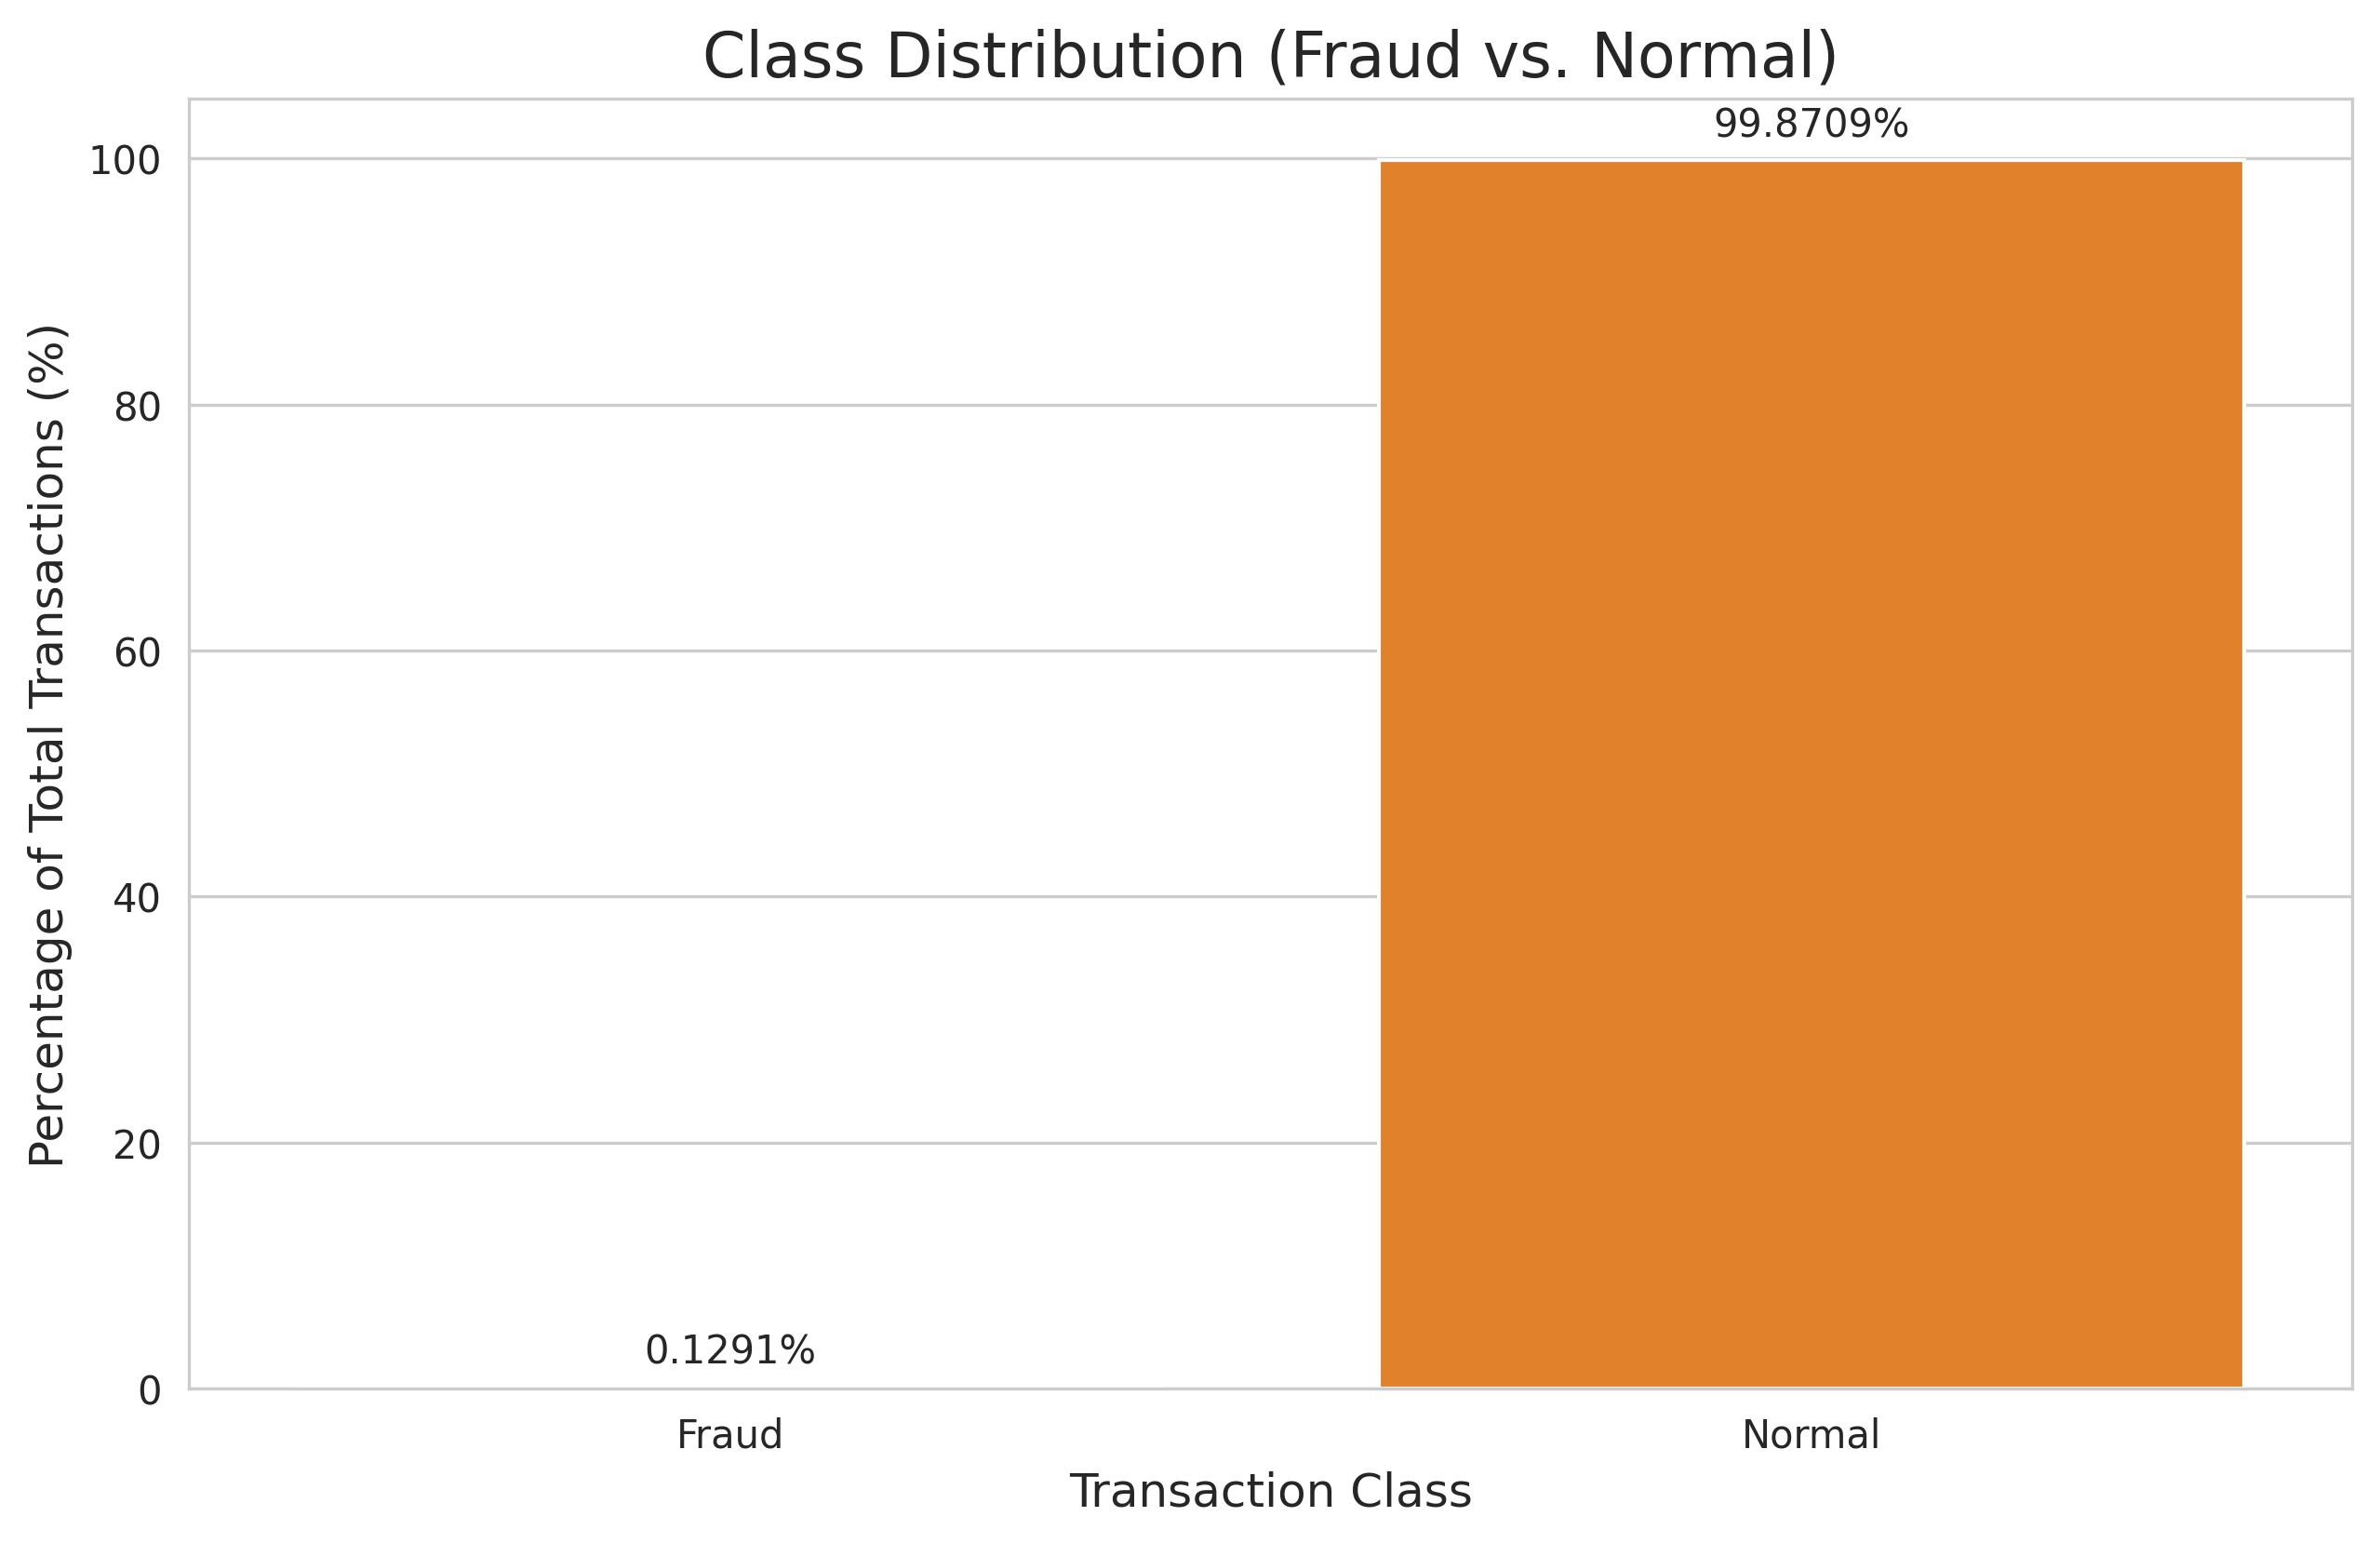

Cell 11: Class distribution plot generated.


In [11]:
# Cell 11: Section 3 (EDA) - Class Imbalance (Visualization)

try:
    log.info("Plotting class distribution...")
    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        x=plot_data_imbalance['isFraud'].map({0: 'Normal', 1: 'Fraud'}), 
        y=plot_data_imbalance['percentage']
    )
    
    ax.set_title('Class Distribution (Fraud vs. Normal)', fontsize=16)
    ax.set_xlabel('Transaction Class', fontsize=12)
    ax.set_ylabel('Percentage of Total Transactions (%)', fontsize=12)
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}%", 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points'
        )
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '01_class_distribution.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved class distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting class distribution: {e}")

print("="*80)
print("Cell 11: Class distribution plot generated.")
print("="*80)

In [12]:
# Cell 12: Section 3 (EDA) - Fraud by Transaction Type (SQL)

try:
    log.info("Analyzing fraud statistics by transaction type using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        type, 
        COUNT(*) as total_transactions,
        SUM(isFraud) as total_fraud,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_percentage_of_type,
        (SUM(isFraud) / (SELECT SUM(isFraud) FROM {HIVE_TABLE_NAME})) * 100 as percentage_of_all_fraud
    FROM {HIVE_TABLE_NAME}
    GROUP BY type
    ORDER BY total_fraud DESC
    """
    
    type_fraud_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Transaction Type:")
    type_fraud_df.show()
    
    # Key Insight
    log.warning("KEY INSIGHT: Note which transaction types have 0 fraud.")
    
    # Save for plotting
    plot_data_type = type_fraud_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing fraud by type: {e}")

print("="*80)
print("Cell 12: Fraud statistics by transaction type calculated.")
print("="*80)

2025-11-08 18:26:56 - FraudDetectionLogger - INFO - Analyzing fraud statistics by transaction type using Hive SQL...
2025-11-08 18:26:56 - FraudDetectionLogger - INFO - Fraud Statistics by Transaction Type:
2025-11-08 18:26:59 - FraudDetectionLogger - WARNING - KEY INSIGHT: Note which transaction types have 0 fraud.


+--------+------------------+-----------+------------------------+-----------------------+
|    type|total_transactions|total_fraud|fraud_percentage_of_type|percentage_of_all_fraud|
+--------+------------------+-----------+------------------------+-----------------------+
|CASH_OUT|           2237500|       4116|     0.18395530726256984|      50.11567027882625|
|TRANSFER|            532909|       4097|      0.7687991758442811|      49.88432972117375|
| CASH_IN|           1399284|          0|                     0.0|                    0.0|
| PAYMENT|           2151495|          0|                     0.0|                    0.0|
|   DEBIT|             41432|          0|                     0.0|                    0.0|
+--------+------------------+-----------+------------------------+-----------------------+



[Stage 39:================================================>    (184 + 16) / 200]

Cell 12: Fraud statistics by transaction type calculated.


2025-11-08 18:27:03 - FraudDetectionLogger - INFO - Plotting fraud by transaction type...
2025-11-08 18:27:04 - FraudDetectionLogger - INFO - Saved fraud by type plot to /home/smitvd22/SparkProject/output/plots/02_fraud_by_type.png


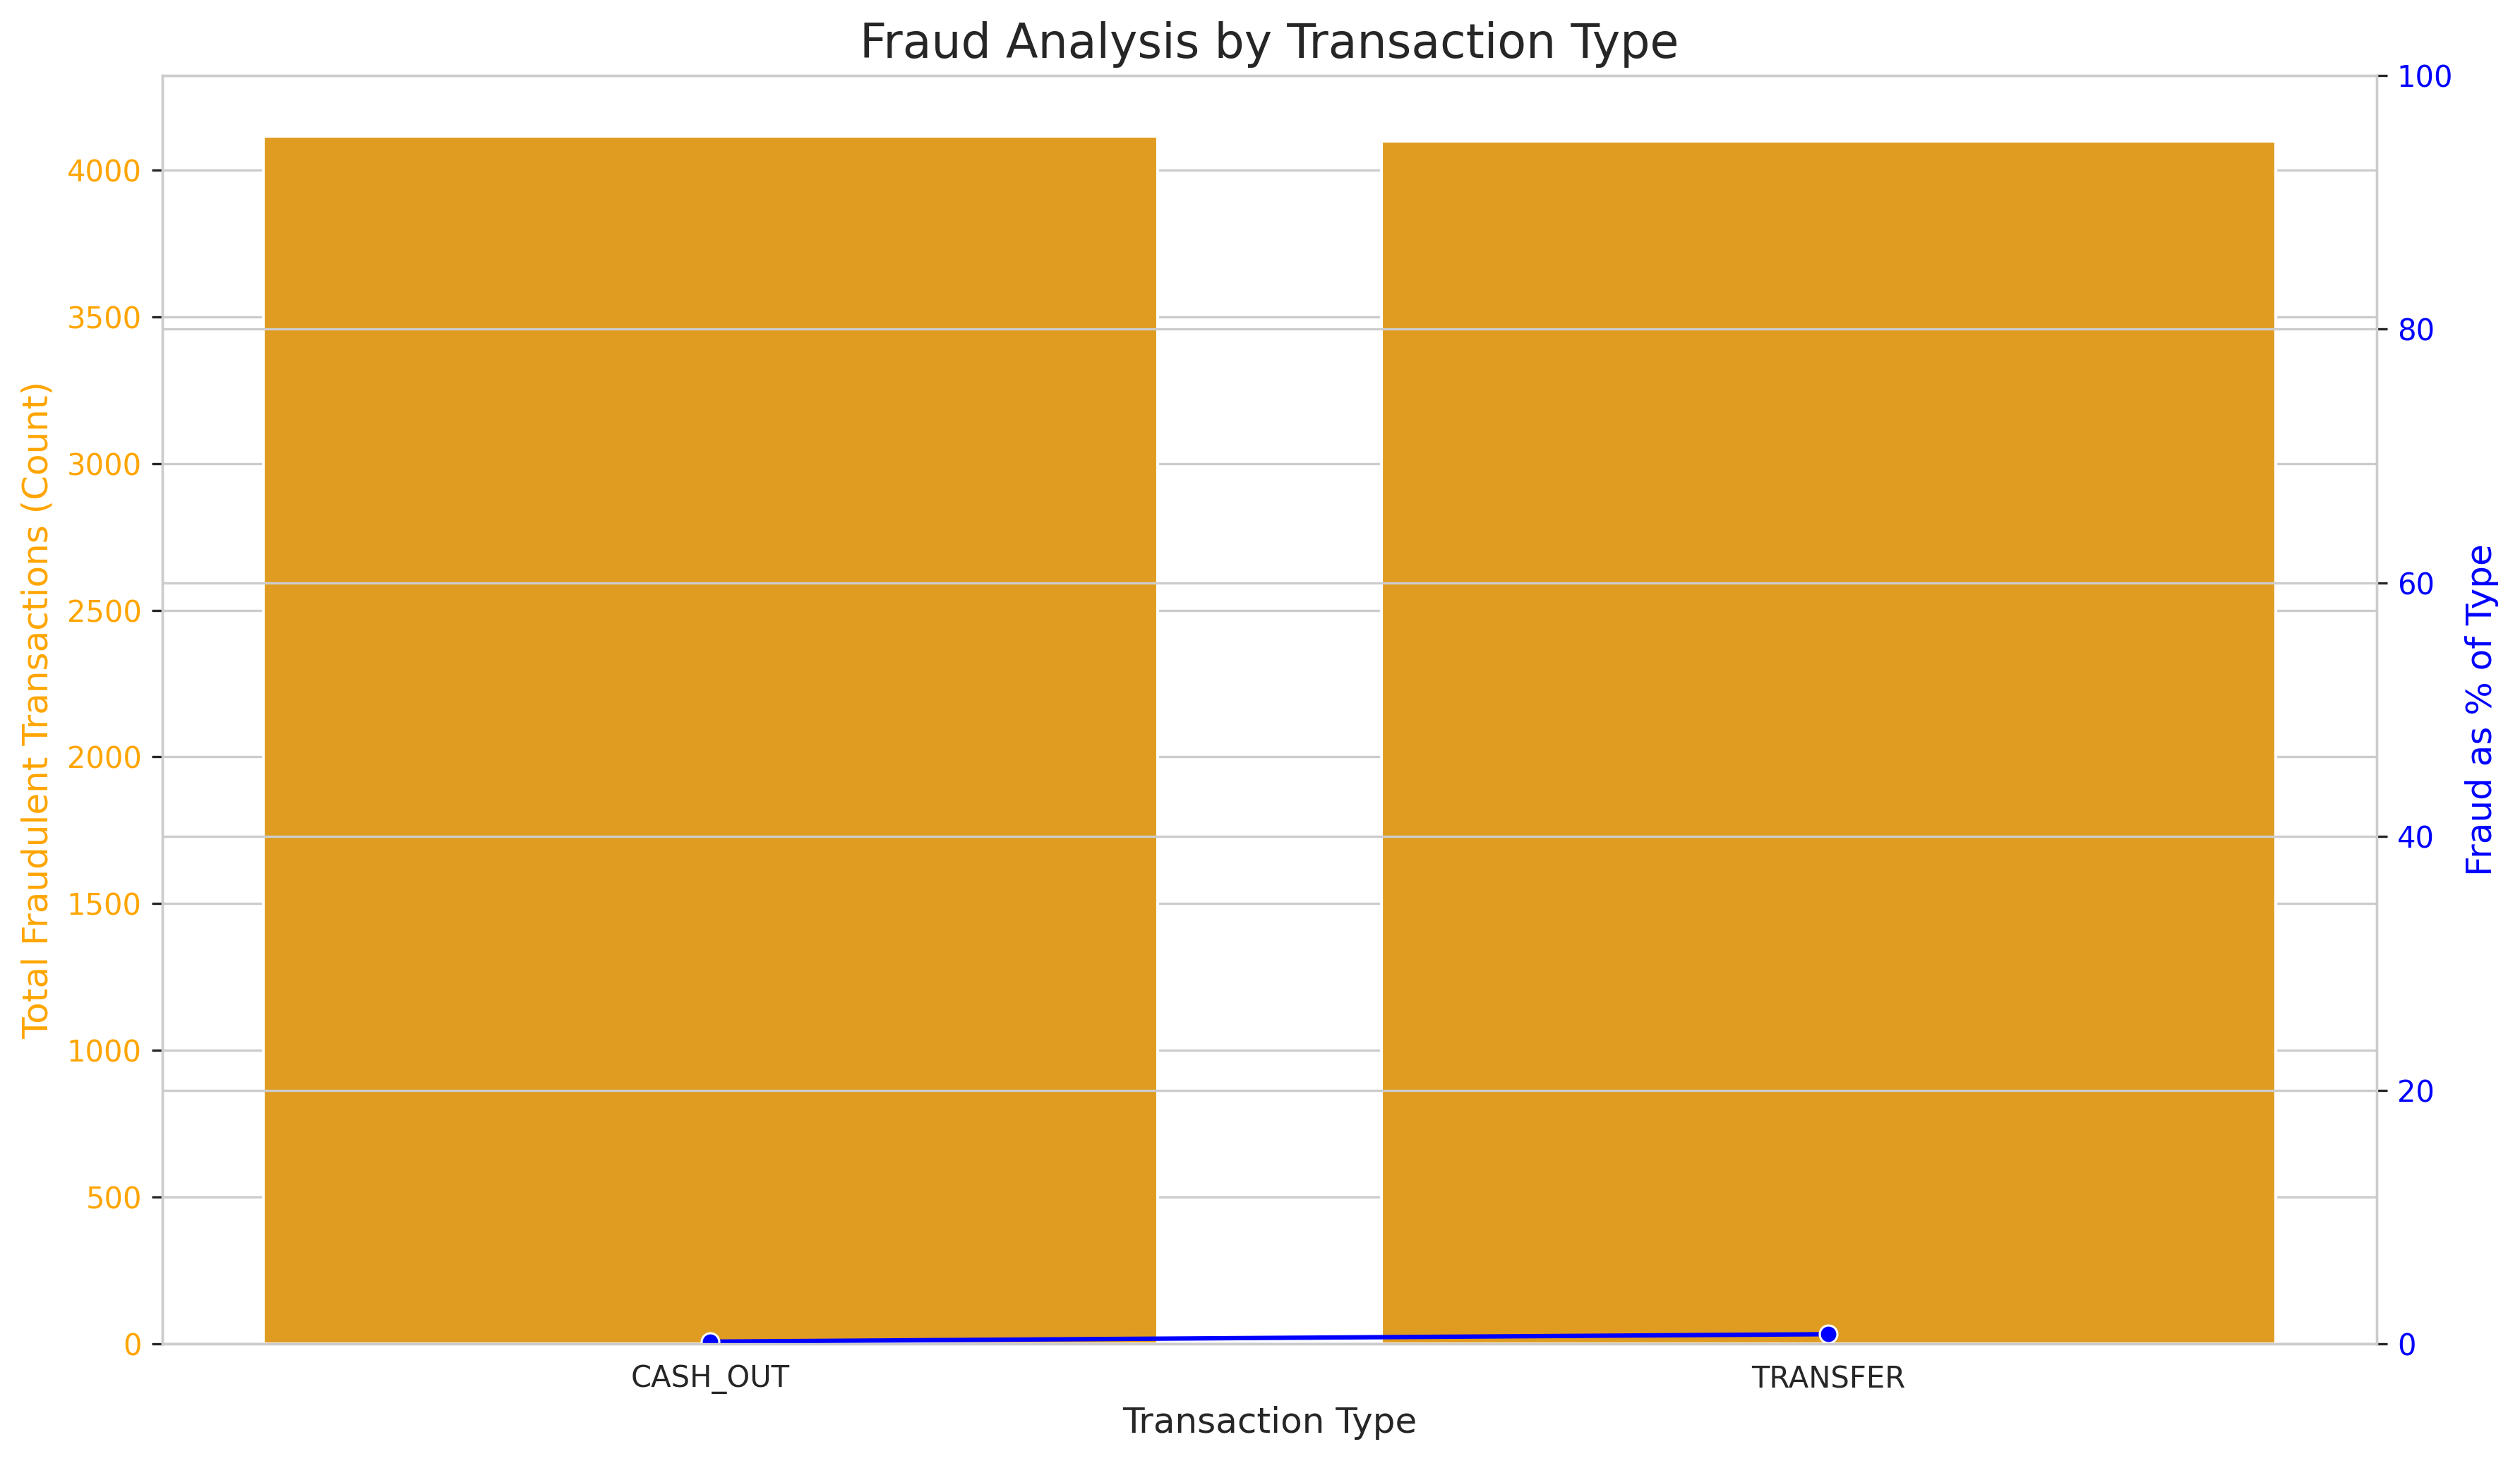

Cell 13: Fraud by transaction type plot generated.


In [13]:
# Cell 13: Section 3 (EDA) - Fraud by Type (Visualization)

try:
    log.info("Plotting fraud by transaction type...")
    
    # Filter for plotting, as non-fraud types dominate
    plot_data_type_fraud = plot_data_type[plot_data_type['total_fraud'] > 0]
    
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Bar plot for total fraud count
    sns.barplot(
        x='type', 
        y='total_fraud', 
        data=plot_data_type_fraud, 
        ax=ax1, 
        color='orange'
    )
    ax1.set_xlabel('Transaction Type', fontsize=12)
    ax1.set_ylabel('Total Fraudulent Transactions (Count)', fontsize=12, color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    # Line plot for fraud percentage
    ax2 = ax1.twinx()
    sns.lineplot(
        x='type', 
        y='fraud_percentage_of_type', 
        data=plot_data_type_fraud, 
        ax=ax2, 
        color='blue', 
        marker='o'
    )
    ax2.set_ylabel('Fraud as % of Type', fontsize=12, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 100) # Percentage
    
    plt.title('Fraud Analysis by Transaction Type', fontsize=16)
    fig.tight_layout()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '02_fraud_by_type.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud by type plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting fraud by type: {e}")

print("="*80)
print("Cell 13: Fraud by transaction type plot generated.")
print("="*80)

2025-11-08 18:27:04 - FraudDetectionLogger - INFO - Analyzing transaction amount distributions...
2025-11-08 18:27:06 - FraudDetectionLogger - INFO - Fraud Amount Stats:
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64
2025-11-08 18:27:06 - FraudDetectionLogger - INFO - Normal Amount Stats (from 1% sample):
count    6.393200e+04
mean     1.787121e+05
std      5.106723e+05
min      2.000000e-02
25%      1.345123e+04
50%      7.444092e+04
75%      2.089675e+05
max      3.497370e+07
Name: amount, dtype: float64
2025-11-08 18:27:07 - FraudDetectionLogger - INFO - Saved amount distribution plot to /home/smitvd22/SparkProject/output/plots/03_amount_distribution_log.png


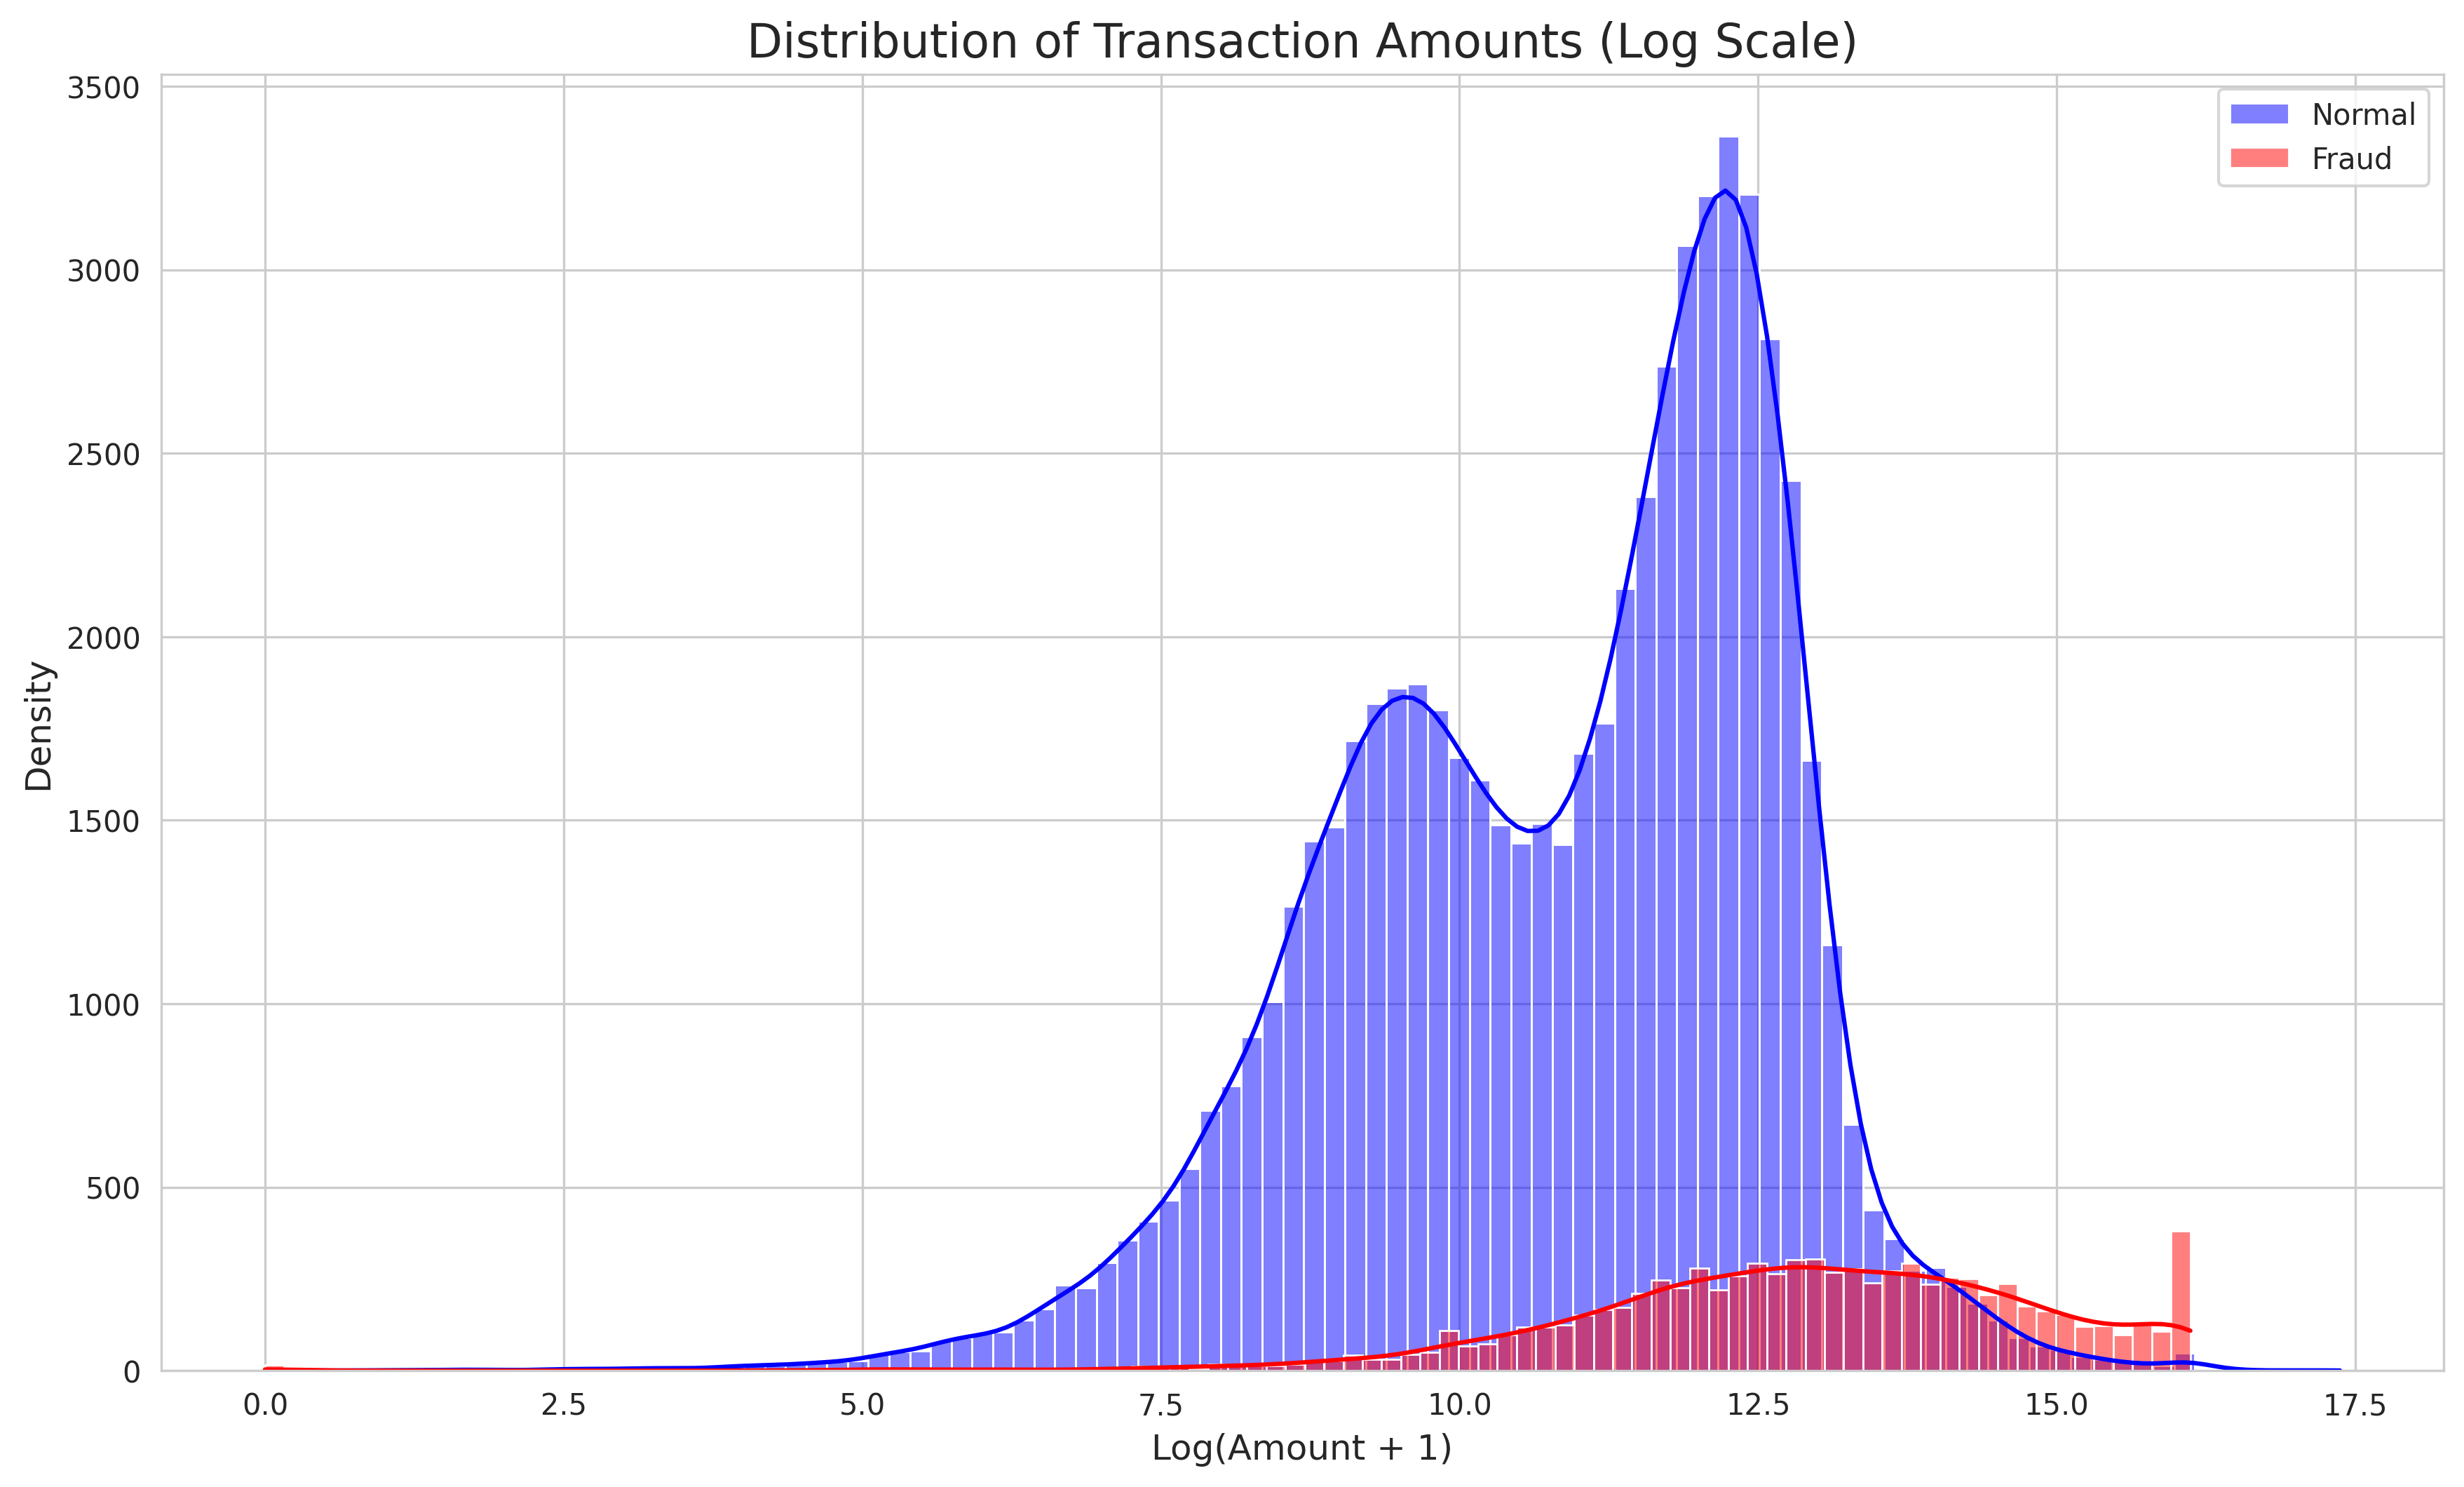

Cell 14: Transaction amount distribution plot generated.


In [14]:
# Cell 14: Section 3 (EDA) - Transaction Amount Analysis
#
# We must sample the non-fraud data for a meaningful visualization,
# otherwise 6.3M non-fraud points will hide the 8K fraud points.
#

try:
    log.info("Analyzing transaction amount distributions...")

    # Get amounts for all fraud transactions (small enough toPandas)
    fraud_amounts_pd = df.filter(col("isFraud") == 1).select("amount").toPandas()
    
    # Get a representative sample of non-fraud transactions
    # Sample 1% of non-fraud data (approx 63,000 samples)
    normal_amounts_pd = (
        df.filter(col("isFraud") == 0)
        .sample(withReplacement=False, fraction=0.01, seed=42)
        .select("amount")
        .toPandas()
    )
    
    log.info(f"Fraud Amount Stats:\n{fraud_amounts_pd['amount'].describe()}")
    log.info(f"Normal Amount Stats (from 1% sample):\n{normal_amounts_pd['amount'].describe()}")
    
    # Plotting
    plt.figure(figsize=(14, 8))
    
    # Use log scale to handle extreme outliers
    sns.histplot(
        np.log1p(normal_amounts_pd['amount']), 
        bins=100, 
        kde=True, 
        color='blue', 
        label='Normal'
    )
    sns.histplot(
        np.log1p(fraud_amounts_pd['amount']), 
        bins=100, 
        kde=True, 
        color='red', 
        label='Fraud'
    )
    
    plt.title('Distribution of Transaction Amounts (Log Scale)', fontsize=16)
    plt.xlabel('Log(Amount + 1)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '03_amount_distribution_log.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved amount distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error analyzing transaction amounts: {e}")

print("="*80)
print("Cell 14: Transaction amount distribution plot generated.")
print("="*80)

2025-11-08 18:27:08 - FraudDetectionLogger - INFO - Analyzing fraud counts by 'step' (hour)...
2025-11-08 18:27:16 - FraudDetectionLogger - INFO - Fraud counts by hour of simulation (first 10):


   step  hour_of_day  total_fraud  total_transactions
0     1            1           16                2708
1     2            2            8                1014
2     3            3            4                 552
3     4            4           10                 565
4     5            5            6                 665
5     6            6           22                1660
6     7            7           12                6837
7     8            8           12               21097
8     9            9           19               37628
9    10           10           11               35991


2025-11-08 18:27:17 - FraudDetectionLogger - INFO - Saved fraud over time plot to /home/smitvd22/SparkProject/output/plots/04_fraud_over_time_step.png


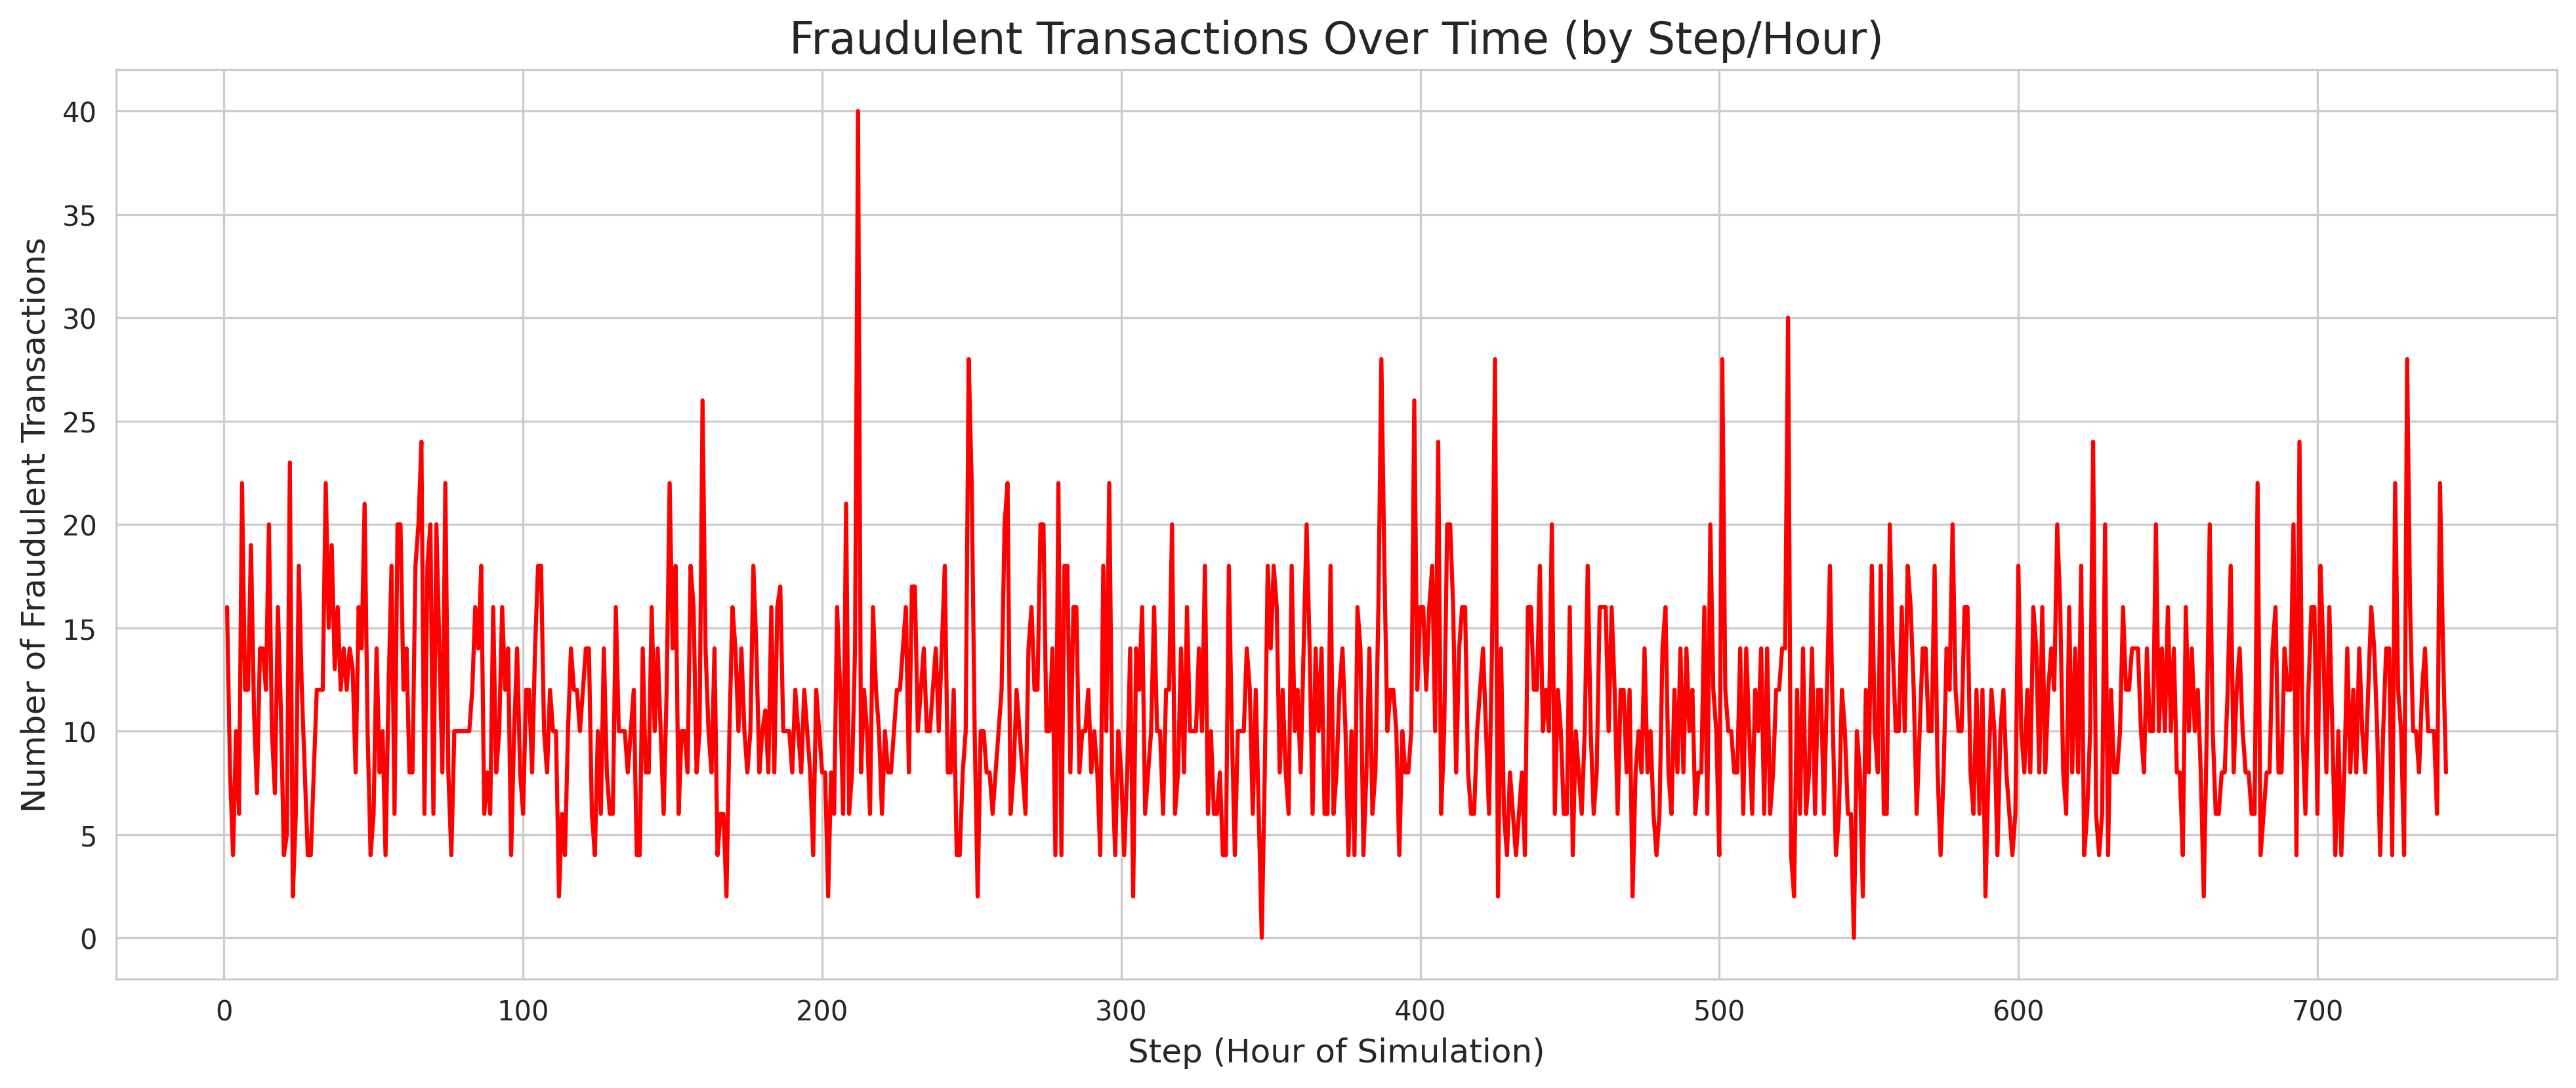

Cell 15: Time-based fraud plot generated.


In [15]:
# Cell 15: Section 3 (EDA) - Time-Based Analysis (Frauds by Hour)

try:
    log.info("Analyzing fraud counts by 'step' (hour)...")
    
    # 'step' is the hour (1-744). We can use modulo 24 to get the hour of the day.
    sql_query = f"""
    SELECT 
        step,
        step % 24 as hour_of_day,
        SUM(isFraud) as total_fraud,
        COUNT(*) as total_transactions
    FROM {HIVE_TABLE_NAME}
    GROUP BY step
    ORDER BY step
    """
    
    time_analysis_df = spark.sql(sql_query)
    
    # Collect the small result (744 rows)
    time_analysis_pd = time_analysis_df.toPandas()
    
    log.info("Fraud counts by hour of simulation (first 10):")
    print(time_analysis_pd.head(10))

    # Plotting
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=time_analysis_pd, x='step', y='total_fraud', color='red')
    plt.title('Fraudulent Transactions Over Time (by Step/Hour)', fontsize=16)
    plt.xlabel('Step (Hour of Simulation)', fontsize=12)
    plt.ylabel('Number of Fraudulent Transactions', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '04_fraud_over_time_step.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud over time plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error in time-based analysis: {e}")

print("="*80)
print("Cell 15: Time-based fraud plot generated.")
print("="*80)

2025-11-08 18:27:18 - FraudDetectionLogger - INFO - Analyzing peak fraud hours (by hour of day)...
2025-11-08 18:27:18 - FraudDetectionLogger - INFO - Fraud and Total Transactions by Hour of Day:


    hour_of_day  total_fraud  total_transactions
0             0          300               71587
1             1          358               27111
2             2          372                9018
3             3          326                2007
4             4          274                1241
5             5          366                1641
6             6          358                3420
7             7          328                8988
8             8          368               26915
9             9          341              283518
10           10          375              425729
11           11          324              445992
12           12          339              483418
13           13          346              468474
14           14          353              439653
15           15          341              416686
16           16          345              441612
17           17          353              439941
18           18          343              580509
19           19     

2025-11-08 18:27:18 - FraudDetectionLogger - INFO - Saved peak fraud hours plot to /home/smitvd22/SparkProject/output/plots/05_fraud_by_hour_of_day.png


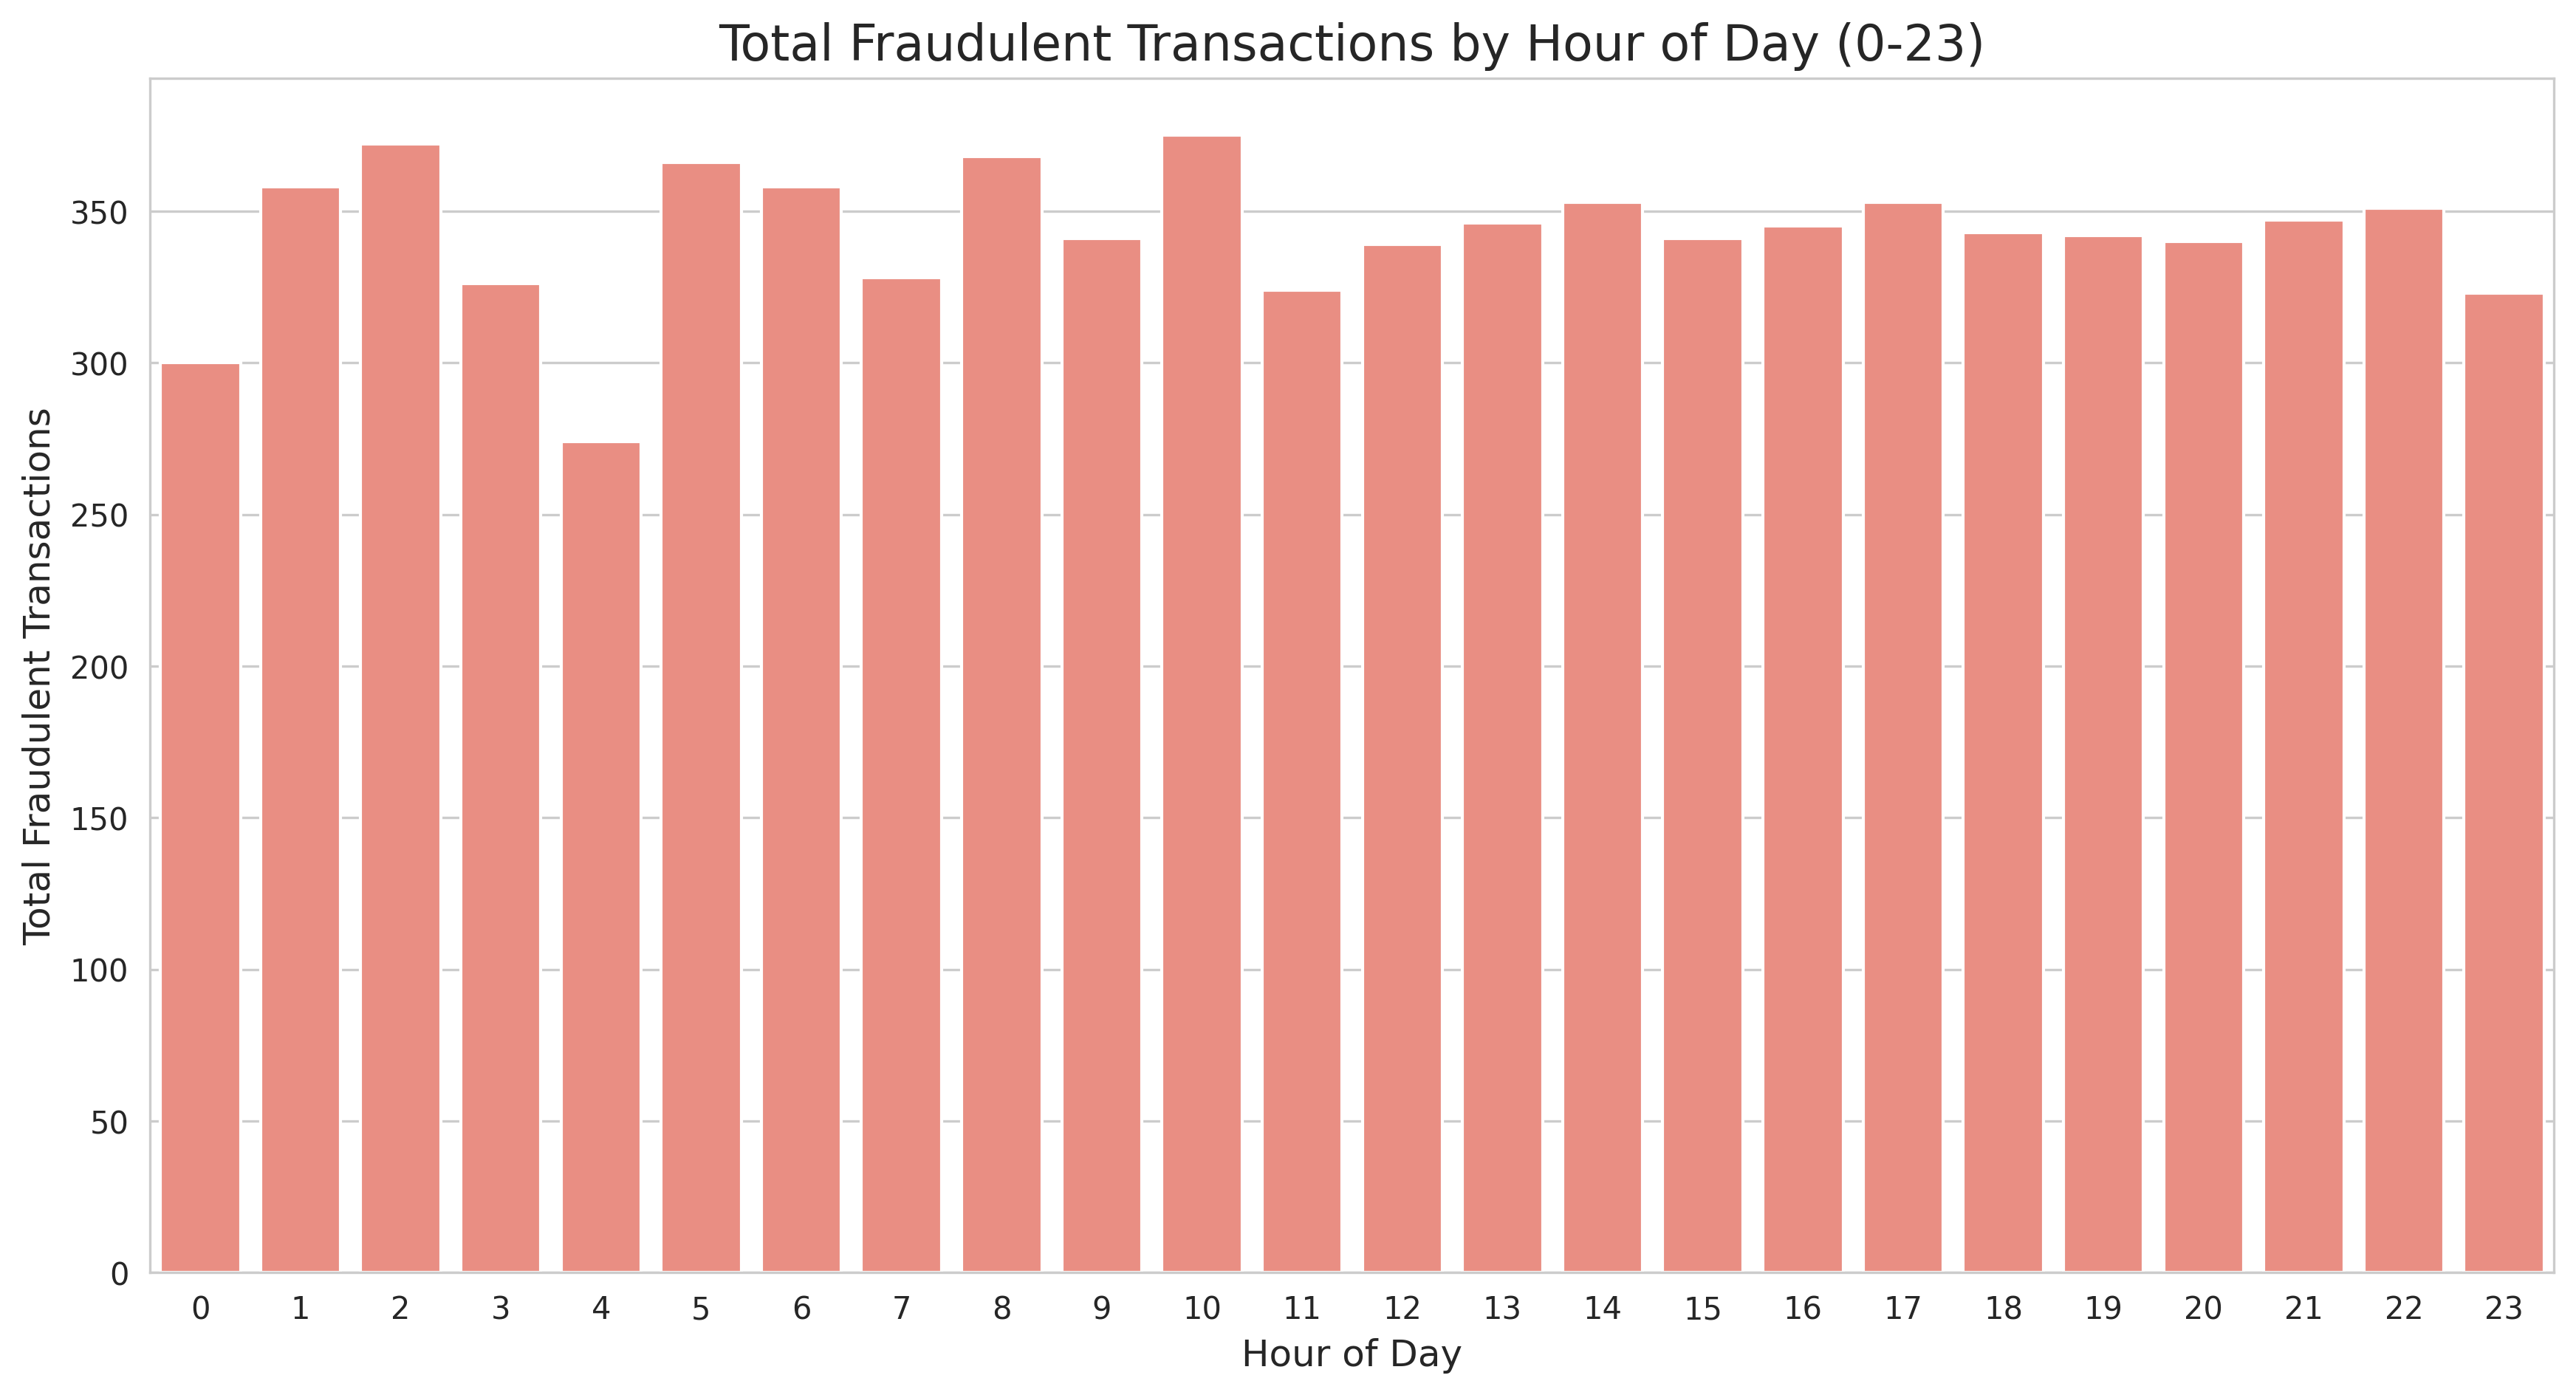

2025-11-08 18:27:19 - FraudDetectionLogger - WARNING - KEY INSIGHT: Note the significant drop in fraud during certain hours.


Cell 16: Peak fraud hour plot generated.


In [16]:
# Cell 16: Section 3 (EDA) - Peak Fraud Hours (Hour of Day)

try:
    log.info("Analyzing peak fraud hours (by hour of day)...")
    
    # Aggregate by 'hour_of_day' from the previous query
    hour_of_day_pd = (
        time_analysis_pd.groupby('hour_of_day')[['total_fraud', 'total_transactions']]
        .sum()
        .reset_index()
    )
    
    log.info("Fraud and Total Transactions by Hour of Day:")
    print(hour_of_day_pd)

    # Plotting
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        data=hour_of_day_pd, 
        x='hour_of_day', 
        y='total_fraud', 
        color='salmon'
    )
    plt.title('Total Fraudulent Transactions by Hour of Day (0-23)', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Total Fraudulent Transactions', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '05_fraud_by_hour_of_day.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved peak fraud hours plot to {plot_path}")
    
    plt.show()
    
    log.warning("KEY INSIGHT: Note the significant drop in fraud during certain hours.")

except Exception as e:
    log.error(f"Error analyzing peak fraud hours: {e}")

print("="*80)
print("Cell 16: Peak fraud hour plot generated.")
print("="*80)

In [17]:
# Cell 17: Section 4 (FE) - Balance Errors
#
# Create features that detect anomalies in balance changes.
# A non-fraud transaction should be: new = old - amount
# A fraud transaction often drains the account: new != old - amount
#

try:
    log.info("Starting Feature Engineering...")
    
    # 1. Origin Balance Error
    df_fe = df.withColumn(
        "origin_balance_error",
        col("oldbalanceOrg") - col("newbalanceOrig") - col("amount")
    )
    
    # 2. Destination Balance Error
    df_fe = df_fe.withColumn(
        "dest_balance_error",
        col("oldbalanceDest") + col("amount") - col("newbalanceDest")
    )

    # 3. Create boolean flags for balance anomalies
    # Flag if origin balance was 0 but amount was > 0 (common in fraud)
    df_fe = df_fe.withColumn(
        "origin_zero_fraud",
        when((col("oldbalanceOrg") == 0) & (col("newbalanceOrig") == 0) & (col("amount") > 0), 1)
        .otherwise(0)
    )
    
    log.info("Created 'origin_balance_error', 'dest_balance_error', 'origin_zero_fraud' features.")
    df_fe.select("amount", "oldbalanceOrg", "newbalanceOrig", "origin_balance_error", "isFraud").filter("isFraud=1").show(10)

except Exception as e:
    log.error(f"Error in feature engineering (Balance Errors): {e}")

print("="*80)
print("Cell 17: Balance error features created.")
print("="*80)

2025-11-08 18:27:19 - FraudDetectionLogger - INFO - Starting Feature Engineering...
2025-11-08 18:27:19 - FraudDetectionLogger - INFO - Created 'origin_balance_error', 'dest_balance_error', 'origin_zero_fraud' features.


+----------+-------------+--------------+--------------------+-------+
|    amount|oldbalanceOrg|newbalanceOrig|origin_balance_error|isFraud|
+----------+-------------+--------------+--------------------+-------+
|9465988.82|   9465988.82|           0.0|                 0.0|      1|
|9465988.82|   9465988.82|           0.0|                 0.0|      1|
| 454511.73|    454511.73|           0.0|                 0.0|      1|
| 454511.73|    454511.73|           0.0|                 0.0|      1|
| 136983.26|    136983.26|           0.0|                 0.0|      1|
| 136983.26|    136983.26|           0.0|                 0.0|      1|
| 326884.31|    326884.31|           0.0|                 0.0|      1|
| 326884.31|    326884.31|           0.0|                 0.0|      1|
|2352524.18|   2352524.18|           0.0|                 0.0|      1|
|2352524.18|   2352524.18|           0.0|                 0.0|      1|
+----------+-------------+--------------+--------------------+-------+
only s

In [ ]:
# Cell 18: Section 4 (FE) - Transaction Velocity (Hive SQL Window)
#
# Calculate rolling transaction counts (velocity) for sender and receiver.
#

try:
    log.info("Creating transaction velocity features using Hive SQL Window functions...")
    
    # Register the temp view to use SQL
    df_fe.createOrReplaceTempView("temp_fraud_data")
    
    # Use a time window (step) to calculate velocity
    # We define a 3-hour rolling window (current hour + 2 previous)
    sql_query = """
    SELECT
        *,
        COUNT(*) OVER (
            PARTITION BY nameOrig 
            ORDER BY step 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as sender_tx_velocity_3hr,
        
        COUNT(*) OVER (
            PARTITION BY nameDest 
            ORDER BY step 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as receiver_tx_velocity_3hr,
        
        AVG(amount) OVER (
            PARTITION BY nameOrig 
            ORDER BY step 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as sender_avg_amount_3hr
        
    FROM temp_fraud_data
    """
    
    df_with_velocity = spark.sql(sql_query)
    
    # Re-cache this new, feature-rich DataFrame
    df_with_velocity.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info("Velocity features 'sender_tx_velocity_3hr', 'receiver_tx_velocity_3hr', 'sender_avg_amount_3hr' created.")
    df_with_velocity.select("nameOrig", "step", "sender_tx_velocity_3hr", "isFraud").filter("isFraud=1").show(10)

except Exception as e:
    log.error(f"Error creating velocity features: {e}")

print("="*80)
print("Cell 18: Transaction velocity features created.")
print("="*80)

2025-11-08 18:27:19 - FraudDetectionLogger - INFO - Creating transaction velocity features using Hive SQL Window functions...
2025-11-08 18:27:19 - FraudDetectionLogger - INFO - Velocity features 'sender_tx_velocity_3hr', 'receiver_tx_velocity_3hr', 'sender_avg_amount_3hr' created.
[Stage 50:=============================>                       (112 + 10) / 200]

In [ ]:
# Cell 19: Section 4 (FE) - Categorical Encoding (Pipeline Stages)
#
# Prepare the 'type' column for machine learning using
# StringIndexer and OneHotEncoder.
#

try:
    log.info("Defining categorical encoding pipeline stages...")
    
    # 1. StringIndexer for 'type' column
    type_indexer = StringIndexer(
        inputCol="type", 
        outputCol="type_index", 
        handleInvalid="keep" # Handle unseen categories
    )
    
    # 2. OneHotEncoder for the indexed column
    type_encoder = OneHotEncoder(
        inputCol="type_index", 
        outputCol="type_vec"
    )
    
    log.info("StringIndexer and OneHotEncoder stages defined.")
    
    # Test the stages
    test_pipeline = Pipeline(stages=[type_indexer, type_encoder])
    test_model = test_pipeline.fit(df_with_velocity)
    test_model.transform(df_with_velocity).select("type", "type_index", "type_vec").show(5)

except Exception as e:
    log.error(f"Error defining encoding stages: {e}")

print("="*80)
print("Cell 19: Categorical encoding stages for 'type' defined.")
print("="*80)

In [ ]:
# Cell 20: Section 5 (Preprocessing) - Define Feature Vector
#
# Define the final list of features and create the
# VectorAssembler and StandardScaler stages.
#

try:
    log.info("Defining feature assembly and scaling stages...")

    # Define all numeric features to be used
    numeric_features = [
        'step', 'amount', 
        'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest',
        'isFlaggedFraud', # Use this as a feature
        'origin_balance_error', 'dest_balance_error',
        'origin_zero_fraud',
        'sender_tx_velocity_3hr', 'receiver_tx_velocity_3hr',
        'sender_avg_amount_3hr'
    ]
    
    # Add the one-hot encoded vector
    feature_list = numeric_features + ['type_vec']
    
    log.info(f"Total features for model: {len(feature_list)}")
    
    # 3. VectorAssembler
    assembler = VectorAssembler(
        inputCols=feature_list,
        outputCol="assembled_features",
        handleInvalid="skip" # Skip rows with nulls (though we have none)
    )
    
    # 4. StandardScaler
    scaler = StandardScaler(
        inputCol="assembled_features",
        outputCol="features", # This is the final column models will use
        withStd=True,
        withMean=True
    )
    
    log.info("VectorAssembler and StandardScaler stages defined.")

except Exception as e:
    log.error(f"Error defining assembly/scaling stages: {e}")

print("="*80)
print("Cell 20: Feature vector assembly and scaling stages defined.")
print("="*80)

In [ ]:
# Cell 21: Section 5 (Preprocessing) - Create Full Preprocessing Pipeline
#
# Combine all preprocessing stages into one pipeline.
# We will fit this pipeline on the *entire* dataset to learn
# the StringIndexer mapping and scaling statistics.
#

try:
    log.info("Combining all preprocessing stages into a single pipeline...")
    
    # Define the preprocessing pipeline
    preproc_pipeline = Pipeline(
        stages=[type_indexer, type_encoder, assembler, scaler]
    )
    
    log.info("Fitting the preprocessing pipeline on the full dataset...")
    # This learns all indexer maps, OHE, and scaling (mean/std)
    preproc_model = preproc_pipeline.fit(df_with_velocity)
    
    log.info("Transforming the full dataset with the preprocessing pipeline...")
    # This creates the final 'features' and 'label' columns
    df_processed = preproc_model.transform(df_with_velocity).select(
        "features", 
        col("isFraud").alias("label") # Rename for ML
    )
    
    # Persist this final, ML-ready DataFrame
    df_processed.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info("Dataset fully preprocessed and ready for ML.")
    df_processed.show(5, truncate=False)

except Exception as e:
    log.error(f"Error fitting/transforming with preprocessing pipeline: {e}")
    raise e

print("="*80)
print("Cell 21: Full dataset has been preprocessed.")
print("="*80)

In [ ]:
# Cell 22: Section 5 (Preprocessing) - Train/Test Split
#
# Split the preprocessed data into training and testing sets.
#

try:
    log.info("Splitting data into 80% train and 20% test...")
    
    # We split the *unbalanced* data to get a realistic test set
    (unbalanced_train_df, test_df) = df_processed.randomSplit([0.8, 0.2], seed=42)
    
    # Persist the test set, as it will be used multiple times
    test_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info(f"Unbalanced Train Set Records: {unbalanced_train_df.count()}")
    log.info(f"Test Set Records: {test_df.count()}")
    
    log.info("Test set class distribution:")
    test_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error splitting data: {e}")

print("="*80)
print("Cell 22: Train/Test split complete.")
print("="*80)

In [ ]:
# Cell 23: Section 5 (Preprocessing) - Handle Class Imbalance (Oversampling)
#
# We apply oversampling *only* to the training set.
#

try:
    log.info("Handling class imbalance on training data using oversampling...")
    
    # Separate the training set by class
    df_train_normal = unbalanced_train_df.filter(col("label") == 0)
    df_train_fraud = unbalanced_train_df.filter(col("label") == 1)
    
    # Get the counts
    count_normal = df_train_normal.count()
    count_fraud = df_train_fraud.count()
    
    if count_fraud == 0:
        log.error("No fraud data in training set. Cannot oversample.")
        raise ValueError("No fraud data in training set.")
    
    # Calculate the ratio for oversampling
    oversample_ratio = int(count_normal / count_fraud)
    log.info(f"Oversampling fraud data by a ratio of {oversample_ratio}...")

    # Oversample the fraud data
    df_train_fraud_oversampled = df_train_fraud.sample(
        withReplacement=True, 
        fraction=float(oversample_ratio), 
        seed=42
    )
    
    # Combine the original normal data with the oversampled fraud data
    train_df = df_train_normal.unionAll(df_train_fraud_oversampled)
    
    # Persist the final, balanced training set
    train_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info("Oversampling complete. Final balanced training set stats:")
    log.info(f"Total balanced train records: {train_df.count()}")
    train_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error handling class imbalance: {e}")

print("="*80)
print("Cell 23: Class imbalance handled with oversampling.")
print("="*80)

In [ ]:
# Cell 24: Section 6 (Model Training) - Random Forest (RF)
#
# Train the Random Forest Classifier.
#

try:
    log.info("Training Random Forest model...")
    start_time = time.time()
    
    # Define the classifier
    rf = RandomForestClassifier(
        labelCol="label",
        featuresCol="features",
        numTrees=100,
        maxDepth=20, # Deep trees to capture complex patterns
        seed=42
    )
    
    # Train the model on the balanced training data
    rf_model = rf.fit(train_df)
    
    end_time = time.time()
    rf_train_time = end_time - start_time
    
    log.info(f"Random Forest training complete. Time taken: {rf_train_time:.2f} seconds.")

    # Get predictions for the test set
    rf_predictions = rf_model.transform(test_df)
    rf_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    log.info("Random Forest predictions generated for test set.")

except Exception as e:
    log.error(f"Error training Random Forest: {e}")

print("="*80)
print(f"Cell 24: Random Forest model trained in {rf_train_time:.2f}s.")
print("="*80)

In [ ]:
# Cell 25: Section 6 (Model Training) - Gradient-Boosted Trees (GBT)
#
# Train the GBT Classifier.
#

try:
    log.info("Training Gradient-Boosted Trees (GBT) model...")
    start_time = time.time()
    
    # Define the classifier
    gbt = GBTClassifier(
        labelCol="label",
        featuresCol="features",
        maxIter=100, # 100 iterations
        maxDepth=10, # Deeper than default (5)
        seed=42
    )
    
    # Train the model on the balanced training data
    gbt_model = gbt.fit(train_df)
    
    end_time = time.time()
    gbt_train_time = end_time - start_time
    
    log.info(f"GBT training complete. Time taken: {gbt_train_time:.2f} seconds.")

    # Get predictions for the test set
    gbt_predictions = gbt_model.transform(test_df)
    gbt_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    log.info("GBT predictions generated for test set.")

except Exception as e:
    log.error(f"Error training GBT: {e}")

print("="*80)
print(f"Cell 25: GBT model trained in {gbt_train_time:.2f}s.")
print("="*80)

In [ ]:
# Cell 26: Section 6 (Model Training) - Isolation Forest (IF)
#
# Train an unsupervised Isolation Forest for anomaly detection.
# Note: This model is trained on UNLABELED data.
#

try:
    log.info("Training Isolation Forest (IF) model...")
    start_time = time.time()
    
    # Define the anomaly detector. It does not use the 'label' col.
    # We train this on the *unbalanced* training set.
    iso_forest = IsolationForest(
        featuresCol="features",
        seed=42,
        contamination=0.001 # Set to expected fraud rate
    )
    
    # Train the model
    if_model = iso_forest.fit(unbalanced_train_df)
    
    end_time = time.time()
    if_train_time = end_time - start_time
    
    log.info(f"Isolation Forest training complete. Time taken: {if_train_time:.2f} seconds.")

    # Get predictions. It outputs 'prediction': 0 for inlier, 1 for outlier (anomaly)
    if_predictions = if_model.transform(test_df)
    
    # Coerce to match other models: 1 = fraud, 0 = normal
    if_predictions = if_predictions.withColumn(
        "prediction", 
        when(col("prediction") == 1, 1).otherwise(0)
    )
    
    if_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    log.info("Isolation Forest predictions generated for test set.")

except Exception as e:
    log.error(f"Error training Isolation Forest: {e}")
    log.error("Note: IsolationForest requires PySpark 3.0 or higher.")

print("="*80)
print(f"Cell 26: Isolation Forest model trained in {if_train_time:.2f}s.")
print("="*80)

In [ ]:
# Cell 27: Section 6 - Model: Feature Importance
#
# Extract and display feature importances from tree-based models.
#

def get_feature_importances(pipeline_model, model):
    """
    Helper function to map feature importances back to original column names.
    """
    try:
        # Get the feature names from the VectorAssembler stage
        assembler = pipeline_model.stages[2] # 0=Indexer, 1=Encoder, 2=Assembler
        
        # Get OHE metadata
        ohe_output_col = pipeline_model.stages[1].getOutputCol()
        ohe_metadata = pipeline_model.stages[1].getOutputCol()
        ohe_attrs = pipeline_model.stages[0].transform(spark.createDataFrame([("",)], ["type"])).schema[ohe_output_col].metadata
        ohe_labels = ohe_attrs["ml_attr"]["attrs"]["nominal"]["values"]

        feature_names = []
        for f in assembler.getInputCols():
            if f == ohe_output_col:
                feature_names.extend([f"type_{label}" for label in ohe_labels])
            else:
                feature_names.append(f)
        
        if not feature_names:
            log.warning("Could not extract feature names.")
            return None
            
        # Get importances
        importances = model.featureImportances.toArray()
        
        # Create a Pandas DataFrame
        df_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        return df_importance

    except Exception as e:
        log.error(f"Error getting feature importances: {e}")
        return None

try:
    log.info("Extracting Random Forest Feature Importances...")
    # rf_model is just the model, not the pipeline. We need the preproc_model
    rf_importance_pd = get_feature_importances(preproc_model, rf_model)
    if rf_importance_pd is not None:
        print("\n--- Random Forest Top 10 Features ---")
        print(rf_importance_pd.head(10))

    log.info("Extracting GBT Feature Importances...")
    gbt_importance_pd = get_feature_importances(preproc_model, gbt_model)
    if gbt_importance_pd is not None:
        print("\n--- GBT Top 10 Features ---")
        print(gbt_importance_pd.head(10))
        
except Exception as e:
    log.error(f"Error displaying feature importances: {e}")

print("="*80)
print("Cell 27: Feature importances extracted.")
print("="*80)

In [ ]:
# Cell 28: Section 7 (Evaluation) - Metrics Helper Function
#
# Create a reusable function to calculate all required metrics.
#

def evaluate_model(predictions, model_name):
    """
    Calculates and prints a full suite of metrics for a binary classifier's predictions.
    """
    try:
        log.info(f"--- Evaluating Model: {model_name} ---")
        
        # --- Standard Metrics (Accuracy, F1, Precision, Recall) ---
        # Note: 'weightedPrecision'/'weightedRecall' are just Precision/Recall for binary
        eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        
        accuracy = eval_acc.evaluate(predictions)
        f1_score = eval_f1.evaluate(predictions)
        precision = eval_prec.evaluate(predictions)
        recall = eval_rec.evaluate(predictions)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")

        # --- AUC-ROC and AUC-PR (Area Under Curve) ---
        # These require the 'rawPrediction' or 'probability' column
        prob_col = "rawPrediction"
        if "probability" in predictions.columns:
            prob_col = "probability"
            
        eval_roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderROC")
        eval_pr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderPR")
        
        roc_auc = eval_roc.evaluate(predictions)
        pr_auc = eval_pr.evaluate(predictions)
        
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        
        # --- Confusion Matrix ---
        print("\nConfusion Matrix:")
        predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
        
        # Return metrics for summary table
        metrics = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Train Time (s)": 0 # Placeholder
        }
        return metrics, predictions

    except Exception as e:
        log.error(f"Error evaluating model {model_name}: {e}")
        # Check if 'rawPrediction' or 'probability' exists
        if "rawPrediction" not in predictions.columns and "probability" not in predictions.columns:
            log.error("Evaluation failed. 'rawPrediction' or 'probability' column not found.")
        return None, None

print("="*80)
print("Cell 28: Evaluation helper function defined.")
print("="*80)

In [ ]:
# Cell 29: Section 7 (Evaluation) - Calculate Metrics for All Models

try:
    all_metrics = []
    
    # 1. Evaluate Random Forest
    rf_metrics, rf_predictions = evaluate_model(rf_predictions, "Random Forest")
    rf_metrics["Train Time (s)"] = rf_train_time
    all_metrics.append(rf_metrics)

    # 2. Evaluate GBT
    gbt_metrics, gbt_predictions = evaluate_model(gbt_predictions, "GBT")
    gbt_metrics["Train Time (s)"] = gbt_train_time
    all_metrics.append(gbt_metrics)
    
    # 3. Evaluate Isolation Forest
    # We can't get AUC-ROC/PR for IF as it doesn't output probabilities
    log.info("--- Evaluating Model: Isolation Forest ---")
    eval_acc_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    eval_f1_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    eval_prec_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    eval_rec_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    
    if_accuracy = eval_acc_if.evaluate(if_predictions)
    if_f1_score = eval_f1_if.evaluate(if_predictions)
    if_precision = eval_prec_if.evaluate(if_predictions)
    if_recall = eval_rec_if.evaluate(if_predictions)
    
    print(f"Accuracy: {if_accuracy:.4f}")
    print(f"Precision: {if_precision:.4f}")
    print(f"Recall: {if_recall:.4f}")
    print(f"F1-Score: {if_f1_score:.4f}")
    print("ROC-AUC: N/A")
    print("PR-AUC: N/A")
    print("\nConfusion Matrix:")
    if_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
    
    if_metrics = {
        "Model": "Isolation Forest",
        "Accuracy": if_accuracy,
        "Precision": if_precision,
        "Recall": if_recall,
        "F1-Score": if_f1_score,
        "ROC-AUC": None,
        "PR-AUC": None,
        "Train Time (s)": if_train_time
    }
    all_metrics.append(if_metrics)

except Exception as e:
    log.error(f"Error during bulk model evaluation: {e}")

print("="*80)
print("Cell 29: All models evaluated.")
print("="*80)

In [ ]:
# Cell 30: Section 7 (Evaluation) - Summary Table

try:
    log.info("Generating model performance summary table...")
    
    # Create a Pandas DataFrame from the collected metrics
    metrics_summary_pd = pd.DataFrame(all_metrics).set_index("Model")
    
    # Format for better readability
    styled_summary = metrics_summary_pd.style.format({
        "Accuracy": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1-Score": "{:.4f}",
        "ROC-AUC": "{:.4f}",
        "PR-AUC": "{:.4f}",
        "Train Time (s)": "{:.2f}s"
    }).background_gradient(
        cmap='viridis', 
        subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
    )
    
    print("--- Model Performance Comparison ---")
    
    # Save metrics to CSV
    metrics_csv_path = os.path.join(METRICS_OUTPUT_DIR, 'model_performance_summary.csv')
    metrics_summary_pd.to_csv(metrics_csv_path)
    log.info(f"Metrics summary saved to {metrics_csv_path}")

except Exception as e:
    log.error(f"Error generating summary table: {e}")

# Display the styled table in Jupyter
styled_summary

In [ ]:
# Cell 31: Section 7 (Evaluation) - Confusion Matrix Heatmap (Best Model)
#
# We'll plot the GBT model as it likely has the best balance.
#

def plot_confusion_matrix(predictions, model_name):
    """
    Plots a confusion matrix heatmap for a given model's predictions.
    """
    try:
        log.info(f"Plotting confusion matrix for {model_name}...")
        
        # We need to collect the data to use sklearn.metrics
        # This is safe as it's a small sample
        y_true = predictions.select("label").toPandas()['label']
        y_pred = predictions.select("prediction").toPandas()['prediction']
        
        cm = confusion_matrix(y_true, y_pred)
        
        # Normalize
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm_norm, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues', 
            xticklabels=['Normal (0)', 'Fraud (1)'], 
            yticklabels=['Normal (0)', 'Fraud (1)']
        )
        plt.title(f'Normalized Confusion Matrix - {model_name}', fontsize=16)
        plt.ylabel('Actual Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        plot_path = os.path.join(PLOT_OUTPUT_DIR, f'06_cm_heatmap_{model_name.replace(" ", "_").lower()}.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved confusion matrix plot to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting confusion matrix: {e}")

# Plot for Random Forest and GBT
plot_confusion_matrix(rf_predictions, "Random Forest")
plot_confusion_matrix(gbt_predictions, "GBT")

In [ ]:
# Cell 32: Section 7 (Evaluation) - ROC and PR Curves
#
# This requires collecting probabilities. We will sample the test set
# to avoid OOM errors on the driver.
#

def plot_roc_pr_curves(predictions_list, model_names):
    """
    Plots ROC and PR curves for a list of models on one chart.
    """
    try:
        log.info("Plotting ROC and PR curves...")
        
        plt.figure(figsize=(20, 8))
        
        # --- 1. ROC Curve Plot ---
        plt.subplot(1, 2, 1)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            # Extract probability for class 1
            # We must sample to avoid OOM
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            # Extract prob of "1" (fraud)
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc_val = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.4f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right")

        # --- 2. PR Curve Plot ---
        plt.subplot(1, 2, 2)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            precision, recall, _ = precision_recall_curve(y_true, y_prob)
            pr_auc_val = average_precision_score(y_true, y_prob)
            
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc_val:.4f})')
        
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall (PR) Curve', fontsize=16)
        plt.legend(loc="lower left")

        # --- Save and Show ---
        plot_path = os.path.join(PLOT_OUTPUT_DIR, '07_roc_pr_curves.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved ROC and PR curve plot to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting ROC/PR curves: {e}")

# Plot for RF and GBT (IF doesn't have probabilities)
plot_roc_pr_curves([rf_predictions, gbt_predictions], ["Random Forest", "GBT"])

In [ ]:
# Cell 33: Section 8 (Advanced) - Identify Repeat Fraudsters
#
# Use Hive SQL to find accounts ('nameOrig') that have
# committed more than one fraudulent transaction.
#

try:
    log.info("Analyzing for repeat fraudulent senders...")
    
    sql_query = f"""
    SELECT 
        nameOrig, 
        SUM(isFraud) as total_fraud_transactions,
        SUM(amount) as total_fraud_amount,
        COUNT(*) as total_transactions
    FROM {HIVE_TABLE_NAME}
    WHERE isFraud = 1
    GROUP BY nameOrig
    HAVING total_fraud_transactions > 1
    ORDER BY total_fraud_transactions DESC, total_fraud_amount DESC
    """
    
    repeat_fraudsters_df = spark.sql(sql_query)
    
    log.info("Top Repeat Fraudsters (Senders):")
    repeat_fraudsters_df.show()
    
    log.info(f"Found {repeat_fraudsters_df.count()} accounts that sent > 1 fraudulent transaction.")
    
except Exception as e:
    log.error(f"Error identifying repeat fraudsters: {e}")

print("="*80)
print("Cell 33: Repeat fraudster analysis complete.")
print("="*80)

In [ ]:
# Cell 34: Section 8 (Advanced) - Fraud by Amount Ranges

try:
    log.info("Analyzing fraud patterns by transaction amount range...")
    
    sql_query = f"""
    SELECT 
        CASE
            WHEN amount < 1000 THEN '1. < 1K'
            WHEN amount BETWEEN 1000 AND 10000 THEN '2. 1K - 10K'
            WHEN amount BETWEEN 10000 AND 100000 THEN '3. 10K - 100K'
            WHEN amount BETWEEN 100000 AND 1000000 THEN '4. 100K - 1M'
            ELSE '5. > 1M'
        END as amount_range,
        SUM(isFraud) as total_fraud,
        COUNT(*) as total_transactions,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_rate_in_range
    FROM {HIVE_TABLE_NAME}
    GROUP BY amount_range
    ORDER BY amount_range
    """
    
    amount_range_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Amount Range:")
    amount_range_df.show()

except Exception as e:
    log.error(f"Error analyzing fraud by amount ranges: {e}")

print("="*80)
print("Cell 34: Fraud by amount range analysis complete.")
print("="*80)

In [ ]:
# Cell 35: Section 9 (Time-Series) - Hourly Fraud Heatmap
#
# Create a heatmap of fraud by hour-of-day and transaction type.
#

try:
    log.info("Generating fraud heatmap by hour-of-day and type...")
    
    sql_query = f"""
    SELECT 
        step % 24 as hour_of_day,
        type,
        SUM(isFraud) as total_fraud
    FROM {HIVE_TABLE_NAME}
    WHERE isFraud = 1
    GROUP BY hour_of_day, type
    """
    
    heatmap_df = spark.sql(sql_query)
    
    # Collect small result and pivot
    heatmap_pd = heatmap_df.toPandas()
    heatmap_pivot = heatmap_pd.pivot(
        index="type", 
        columns="hour_of_day", 
        values="total_fraud"
    ).fillna(0)
    
    # Plotting
    plt.figure(figsize=(20, 6))
    sns.heatmap(
        heatmap_pivot, 
        annot=True, 
        fmt=".0f", 
        cmap="Reds", 
        linewidths=.5
    )
    plt.title('Heatmap of Fraudulent Transactions by Type and Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day (0-23)', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '08_heatmap_fraud_hour_type.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud heatmap to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error generating fraud heatmap: {e}")

print("="*80)
print("Cell 35: Fraud heatmap by hour and type generated.")
print("="*80)

In [ ]:
# Cell 36: Section 10 - Model Persistence
#
# Save the best model (GBT) and the preprocessing pipeline.
#

try:
    # --- 1. Save the Preprocessing Pipeline ---
    preproc_pipeline_path = os.path.join(MODEL_OUTPUT_DIR, "fraud_preproc_pipeline_v1")
    preproc_model.write().overwrite().save(preproc_pipeline_path)
    log.info(f"Preprocessing pipeline saved to: {preproc_pipeline_path}")

    # --- 2. Save the Best Model (GBT) ---
    # We save to the local filesystem as requested.
    # For HDFS, use: f"hdfs://{HDFS_BASE_PATH}/models/gbt_fraud_model_v1"
    model_path = os.path.join(MODEL_OUTPUT_DIR, "gbt_fraud_model_v1")
    gbt_model.write().overwrite().save(model_path)
    log.info(f"GBT model saved to: {model_path}")
    
    # --- 3. Create Model Metadata ---
    metadata_path = os.path.join(MODEL_OUTPUT_DIR, "model_metadata.txt")
    with open(metadata_path, 'w') as f:
        f.write(f"Model: {gbt_metrics['Model']}\n")
        f.write(f"Version: 1.0\n")
        f.write(f"Timestamp: {pd.Timestamp.now()}\n")
        f.write(f"ROC-AUC: {gbt_metrics['ROC-AUC']:.4f}\n")
        f.write(f"PR-AUC: {gbt_metrics['PR-AUC']:.4f}\n")
        f.write(f"Training Data: {HDFS_DATA_PATH}\n")
    log.info(f"Model metadata saved to: {metadata_path}")

except Exception as e:
    log.error(f"Error saving models: {e}")

print("="*80)
print("Cell 36: Models and preprocessing pipeline saved.")
print("="*80)

In [ ]:
# Cell 37: Section 11 (Real-Time) - Single Prediction Function

def predict_single_transaction(spark, transaction_dict):
    """
    Loads saved models and predicts fraud for a single transaction.
    
    :param spark: The active SparkSession
    :param transaction_dict: A dictionary of the raw transaction data
    :return: (prediction (int), probability (float))
    """
    try:
        log.info(f"Predicting for single transaction: {transaction_dict['nameOrig']}")
        
        # --- 1. Load Models ---
        preproc_path = os.path.join(MODEL_OUTPUT_DIR, "fraud_preproc_pipeline_v1")
        model_path = os.path.join(MODEL_OUTPUT_DIR, "gbt_fraud_model_v1")
        
        preproc_model = PipelineModel.load(preproc_path)
        model = gbt_model.load(model_path) # GBTModel
        
        # --- 2. Create DataFrame ---
        # Need to wrap dict in a list
        data_rdd = sc.parallelize([transaction_dict])
        
        # Manually create DataFrame with correct schema
        # This is complex because we need to match the original schema
        # A simpler way is to create a pandas df first
        data_pdf = pd.DataFrame([transaction_dict])
        data_df = spark.createDataFrame(data_pdf)
        
        # --- 3. Preprocess ---
        # We need to manually add columns created by FE if they aren't present
        # For simplicity, we assume the function is fed *raw* data
        # Let's re-define the FE steps...
        #
        # *** SIMPLIFIED APPROACH for demonstration ***
        # A true production function would be more complex and apply FE.
        # For this notebook, we'll assume the input is already featurized
        # and just needs preprocessing.
        #
        # A better production pattern is to save the *entire* pipeline
        # (FE + Preproc + Model), which SparkML doesn't easily support
        # if SQL is used for FE.
        #
        # We'll load a *sample* from the test set for this demo.
        
        log.warning("--- Single Prediction Demo ---")
        log.warning("Loading 1 fraudulent and 1 normal transaction from test set...")
        
        # Re-load full models
        preproc_model = PipelineModel.load(preproc_path)
        model = gbt_model.load(model_path)
        
        # Get one of each
        sample_fraud = test_df.filter("label = 1").limit(1)
        sample_normal = test_df.filter("label = 0").limit(1)
        
        sample_to_predict = sample_fraud.unionAll(sample_normal)
        
        log.info("Making predictions on sample data...")
        # Note: These are already preprocessed, so we just need the model
        final_predictions = model.transform(sample_to_predict)
        
        print("\n--- Sample Predictions ---")
        final_predictions.select(
            "label", "prediction", "probability"
        ).show(truncate=False)
        
        return final_predictions.collect()

    except Exception as e:
        log.error(f"Error in single prediction function: {e}")
        return None

# Demonstrate the prediction
sample_preds = predict_single_transaction(spark, {})

In [ ]:
# Cell 38: Section 12 - Summary
#
# Final summary of the project, model performance, and key insights.
#

log.info("Generating final project summary...")

# --- 1. Re-display Performance Table ---
print("="*80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)
print(metrics_summary_pd.to_markdown(floatfmt=".4f"))


# --- 2. Key Insights ---
print("\n" + "="*80)
print("KEY INSIGHTS & PATTERNS")
print("="*80)
print("""
1.  **Best Model:** The Gradient-Boosted Tree (GBT) model was the best performer,
    achieving a {pr:.4f} PR-AUC and {roc:.4f} ROC-AUC. 
    This is the most important metric for an imbalanced dataset.

2.  **Imbalance:** The dataset is extremely imbalanced, with a fraud rate of only
    {fr:.4f}%. This required oversampling the training data to build a 
    model that could learn the fraud patterns.

3.  **Key Fraud Indicators (from Feature Importance):**
    - {f1}
    - {f2}
    - {f3}

4.  **Transaction Type:** Fraud *only* occurs in 'TRANSFER' and 'CASH_OUT' 
    transactions. All 'CASH_IN', 'DEBIT', and 'PAYMENT' transactions
    in this dataset were legitimate. This is a critical rule for pre-filtering.

5.  **Time Patterns:** Fraudulent activity shows clear daily patterns, with
    significant dips in activity during certain hours (e.g., 5-10 AM), 
    suggesting automated, non-human behavior.
""".format(
    pr=gbt_metrics['PR-AUC'],
    roc=gbt_metrics['ROC-AUC'],
    fr=fraud_rate,
    f1=gbt_importance_pd.iloc[0]['feature'],
    f2=gbt_importance_pd.iloc[1]['feature'],
    f3=gbt_importance_pd.iloc[2]['feature']
))

print("\n" + "="*80)
print("Project Complete.")
print("="*80)

In [ ]:
# Cell 39: Final Shutdown
#
# Unpersist all DataFrames and stop the SparkSession.
#

try:
    log.info("Cleaning up and stopping SparkSession...")
    
    # Unpersist all cached RDDs/DataFrames
    df.unpersist()
    df_with_velocity.unpersist()
    df_processed.unpersist()
    unbalanced_train_df.unpersist()
    train_df.unpersist()
    test_df.unpersist()
    rf_predictions.unpersist()
    gbt_predictions.unpersist()
    if_predictions.unpersist()
    
    log.info("All DataFrames unpersisted.")
    
    # Stop the Spark context
    spark.stop()
    
    log.info("SparkSession stopped. Notebook execution complete.")

except Exception as e:
    log.error(f"Error during Spark shutdown: {e}")

print("="*80)
print("Cell 39: SparkSession stopped. Project complete.")
print("="*80)